In [1]:
import os
import json
from matplotlib.image import imread, imsave
from matplotlib.pyplot import imshow, show, close
from matplotlib import pyplot as plt
from collections import OrderedDict
import math
import matplotlib.image as mpimg
import cv2
import numpy as np
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection, PolyCollection
import matplotlib.transforms as mtrans

In [9]:
# file paths to read results
read_directory = 'temp/temp3_DQN_train/'
evaluation_folder = read_directory + 'evaluations/'
observation_folder = read_directory + 'observations/'
benchmarks_path = read_directory + 'benchmarks.json'
tensorboard_path = read_directory + 'tensorboard/'
configuration_path = read_directory + 'configuration.json'
slideshow_path = read_directory + 'slideshows/'
if not os.path.exists(slideshow_path):
    os.makedirs(slideshow_path)

In [10]:
# uci primary colors
uci_blue = (0/255, 62/255, 120/255)
uci_gold = (253/255, 185/255, 19/255)

# uci secondary color palette
uci_light_blue = (106/255, 162/255, 184/255)
uci_light_gray = (197/255, 190/255, 181/255)
uci_dark_blue = (27/255, 61/255, 109/255)
uci_orange = (247/255, 141/255, 45/255)
uci_light_yellow = (247/255, 235/255, 95/255)
uci_dark_gray = (85/255, 87/255, 89/255)
uci_lime_green = (122/255, 184/255, 0/255)

# color blind friendly colors
# https://gist.github.com/thriveth/8560036
color_blinds = {
    'blue':   [55/255,  126/255, 184/255],  #377eb8 
    'orange': [255/255, 127/255, 0/255],    #ff7f00
    'green':  [77/255,  175/255, 74/255],   #4daf4a
    'pink':   [247/255, 129/255, 191/255],  #f781bf
    'brown':  [166/255, 86/255,  40/255],   #a65628
    'purple': [152/255, 78/255,  163/255],  #984ea3
    'gray':   [153/255, 153/255, 153/255],  #999999
    'red':    [228/255, 26/255,  28/255],   #e41a1c
    'yellow': [222/255, 222/255, 0/255]     #dede00
}  

# EVALUATIONS

In [11]:
# read evaluations
evaluations = {}
evaluation_files = [file for file in os.listdir(evaluation_folder)]
for evaluation_file in evaluation_files:
    if '.json' not in evaluation_file:
        continue
    evaluation_set_number = int(evaluation_file.split('.')[0])
    evaluations[evaluation_set_number] = json.load(open(evaluation_folder + evaluation_file, 'r'))
evaluations = dict(OrderedDict(sorted(evaluations.items())))
print(json.dumps(evaluations[1], indent=4, sort_keys=True))
# evaluation
    # episode
        # step
            # state

{
    "0": {
        "1": {
            "done": false,
            "drone_position": [
                0.0,
                0.0,
                -4.0
            ],
            "goal_position": [
                1.983365019964855,
                5.662708115167142,
                -4.0
            ],
            "goal_yaw": 1.2338985712628023,
            "has_collided": false,
            "nSteps": 1,
            "observation_component": "V138",
            "reward_from_GoalReward": 1,
            "rl_output": 1.0,
            "total_reward": 1,
            "transcribed_action": "TestAction",
            "yaw": 1.2338986115178356
        },
        "2": {
            "done": true,
            "drone_position": [
                0.0,
                0.0,
                -4.0
            ],
            "goal_position": [
                1.983365019964855,
                5.662708115167142,
                -4.0
            ],
            "goal_yaw": 1.2338985712628023,
            "has_c

In [12]:
evaluations.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100])

In [13]:
# process evaluations
_bin = {'MoveForward':0, 'TestAction':0}
final_variables = {}
for evaluation in evaluations:
    for episode_str in evaluations[evaluation]:
        episode = int(episode_str)
        episode_final_variables = {}
        for step_str in evaluations[evaluation][episode_str]:
            step = int(step_str)
            state = evaluations[evaluation][episode_str][step_str]
            for variable in state:
                if variable == 'transcribed_action':
                    _bin[state[variable]] += 1
                if variable not in final_variables:
                    final_variables[variable] = {}
                if episode not in final_variables[variable]:
                    final_variables[variable][episode] = []
                episode_final_variables[variable] = state[variable]
        for variable in episode_final_variables:
            final_variables[variable][episode].append(episode_final_variables[variable])
#print(json.dumps(final_variables['total_reward'], indent=4, sort_keys=True))
# variable
    # episode
        # final values over all evaluations

In [14]:
_bin

{'MoveForward': 0, 'TestAction': 808}

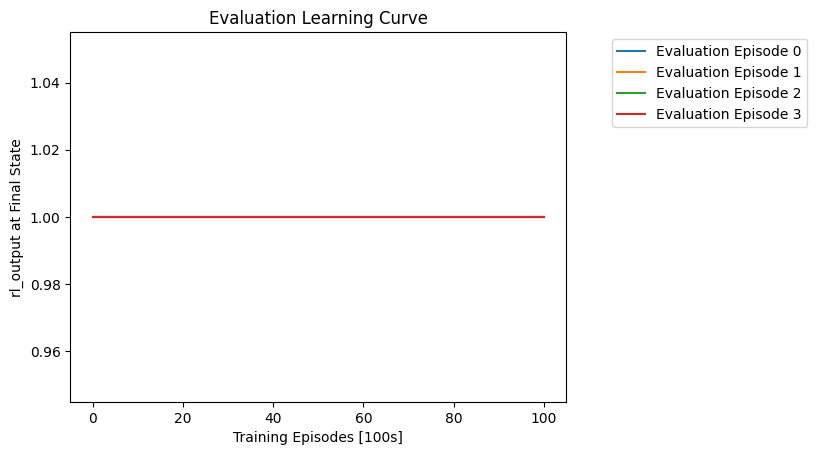

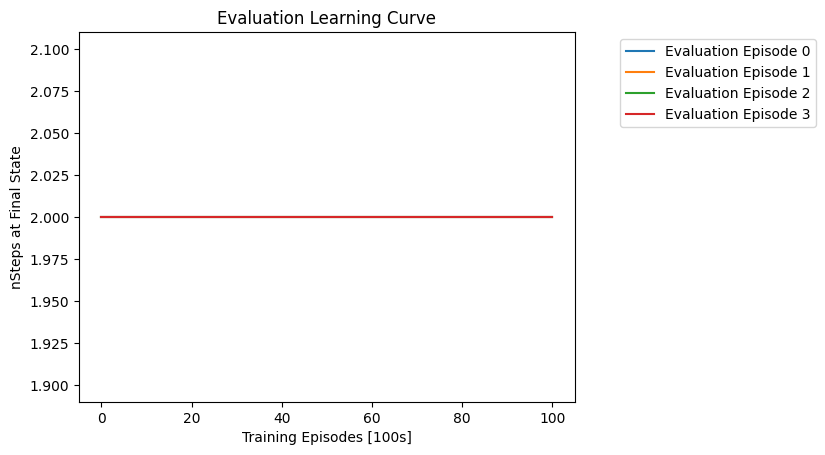

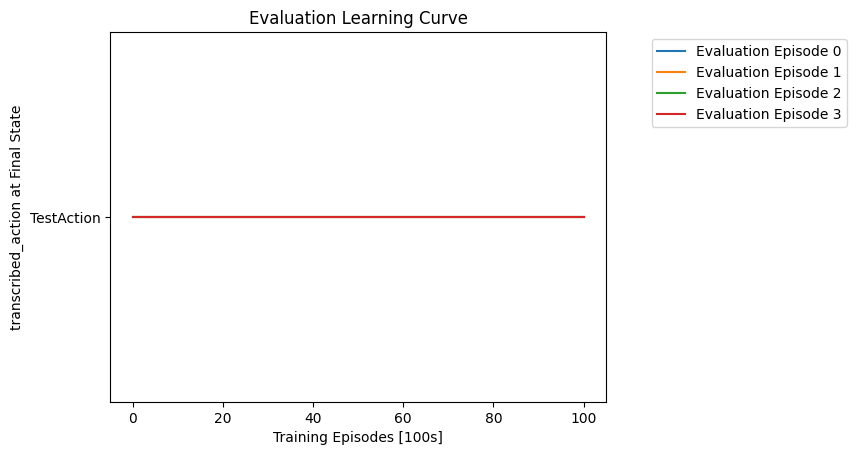

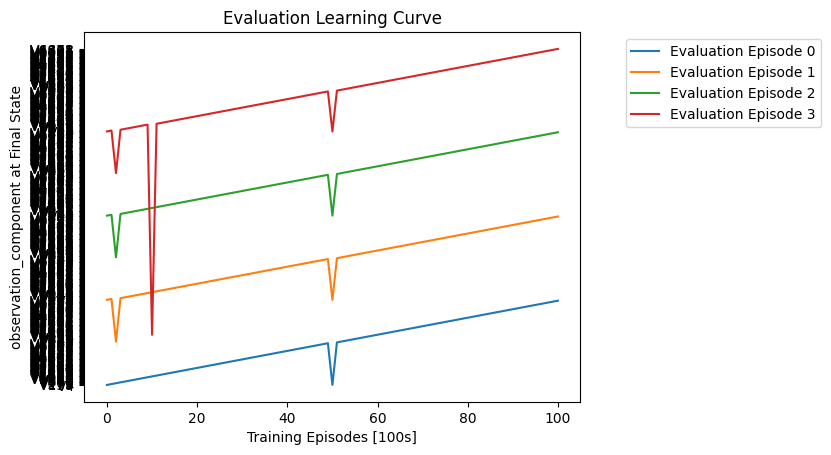

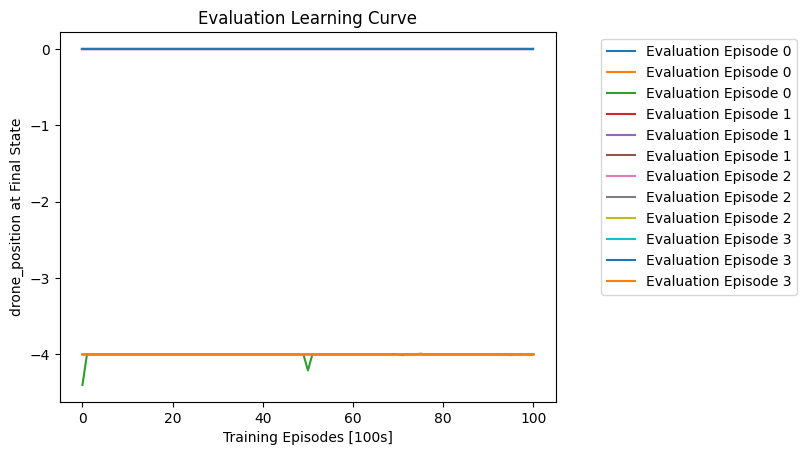

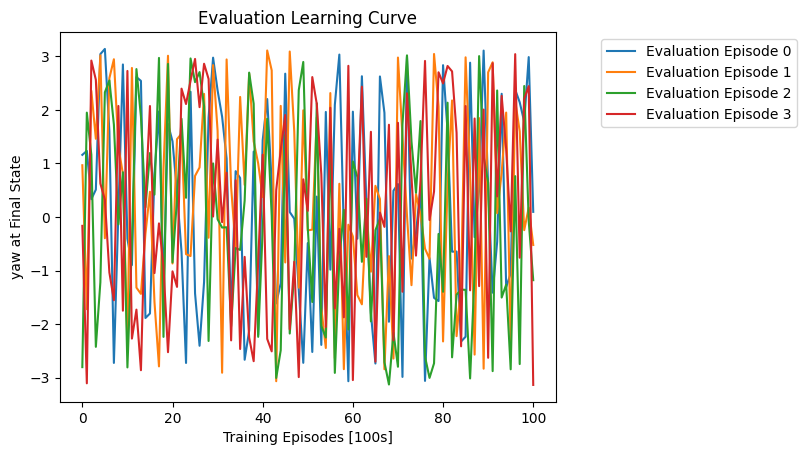

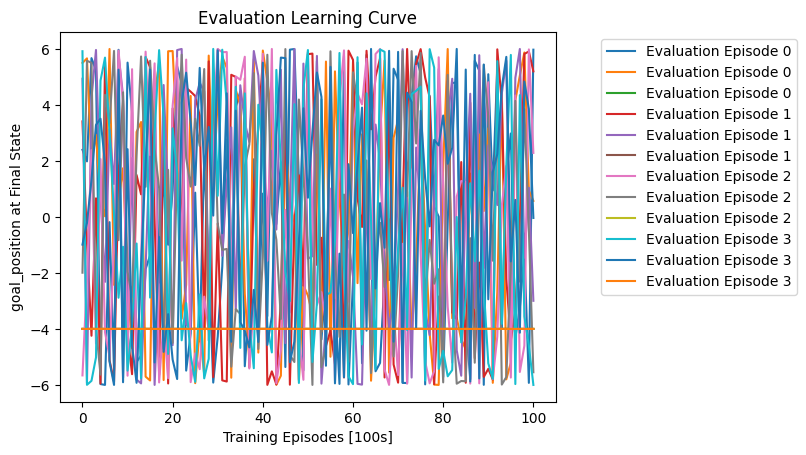

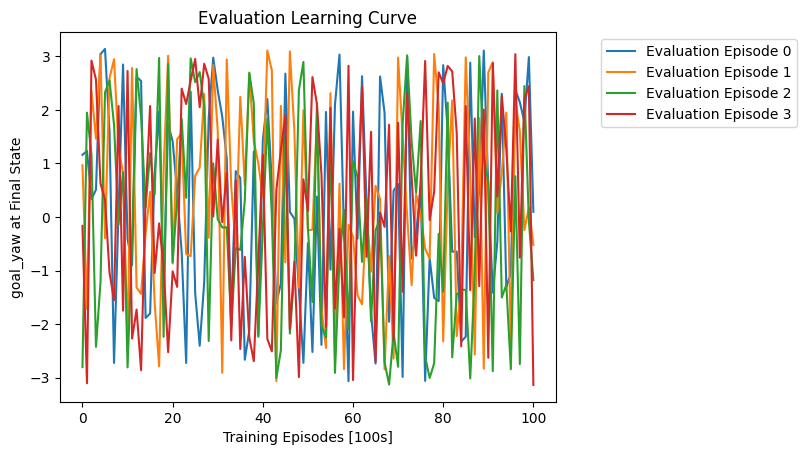

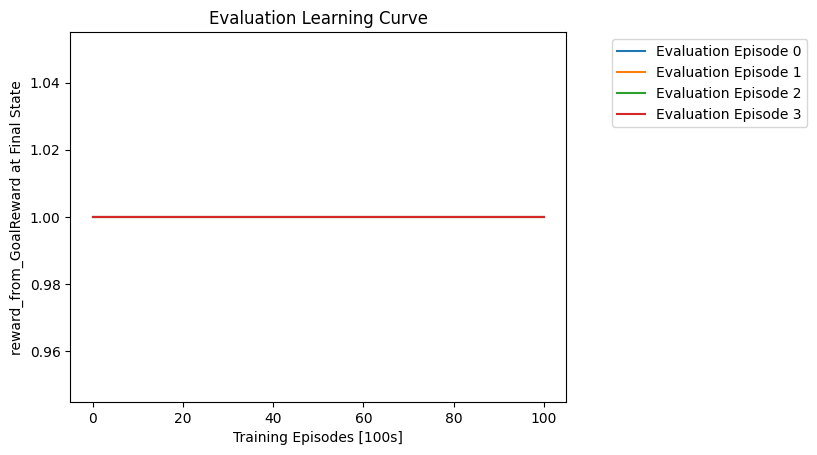

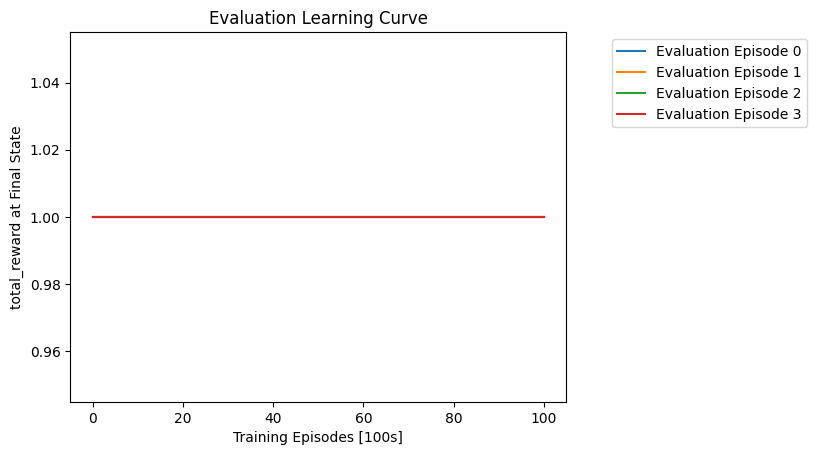

In [ ]:
# plot final values
for variable in final_variables:
    plt.title('Evaluation Learning Curve')
    plt.xlabel('Training Episodes [100s]')
    plt.ylabel(variable + ' at Final State')
    for episode in final_variables[variable]:
        values = final_variables[variable][episode]
        plt.plot(values, label='Evaluation Episode ' + str(episode))
    plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
    plt.show()

In [ ]:
# plot final paths
last_evaluation = list(evaluations.keys())[-1]
last_evaluations = evaluations[last_evaluation]
last_ls = {}
last_xs = {}
last_ys = {}
last_zs = {}
obj_xs = []
obj_ys = []
termination_reasons = []
for episode in last_evaluations:
    last_ls[episode] = []
    last_xs[episode] = []
    last_ys[episode] = []
    last_zs[episode] = []
    first_position = last_evaluations[episode]['1']['drone_position']
    yaw = [math.radians(0), 
           math.radians(135), 
           math.radians(180), 
           math.radians(230)][int(episode)]#last_evaluations[episode]['0']['yaw'] 
    obj_distance = 100
    obj_x = obj_distance * math.cos(yaw)
    obj_y = obj_distance * math.sin(yaw)
    obj_xs.append(obj_x)
    obj_ys.append(obj_y)
    for step in last_evaluations[episode]:
        state = last_evaluations[episode][step]
        position = state['drone_position']
        line_distance = math.sqrt((position[0] - first_position[0])**2 + (position[1] - first_position[1])**2)
        last_ls[episode].append(line_distance)
        last_xs[episode].append(position[0])
        last_ys[episode].append(position[1])
        last_zs[episode].append(position[2])
    termination_reason = last_evaluations[episode][str(len(last_evaluations[episode]))]['termination_reason']
    termination_reasons.append(termination_reason)
object_color = uci_blue
goal_color = uci_lime_green
path_color = uci_gold
for idx, episode in enumerate(last_ls):
    fig = plt.figure()
    fig.set_size_inches((6, 6))
    plt.title('Final Evaluation Path (to scale), Episode ' + str(episode) + ' , end: ' + termination_reasons[idx])
    # custom legend hack
    plt.scatter(-999, -999, marker='s', color=object_color)
    plt.scatter(-999, -999, color=goal_color)
    plt.scatter(-999, -999, color=path_color)
    plt.legend(['Objects', 'Goal', 'Path'])
    plot_map(object_color)
    obj = plt.Circle((obj_ys[idx], obj_xs[idx]), 4, color=goal_color)
    plt.gca().add_patch(obj)
    plt.xlabel('y [meters]')
    plt.ylabel('x [meters]')
    plt.xlim(-120, 120)
    plt.ylim(-120, 120)
    for idx in range(len(last_ys[episode])):
        # using generic quad copter dimensions for point sizes (set this to your drone value)
        radius = 0.5
        point = plt.Circle((last_ys[episode][idx], last_xs[episode][idx]), radius, color=path_color)
        plt.gca().add_patch(point)
    plt.show()

In [ ]:
# get final paths data
last_evaluation = list(evaluations.keys())[-1]
last_evaluations = evaluations[last_evaluation]
observations = {}
state_variables = {}
for episode in last_evaluations:
    observations[episode] = []
    state_variables[episode] = []
    previous_state = last_evaluations[episode]['1']
    first_position = last_evaluations[episode]['1']['drone_position']
    for step in last_evaluations[episode]:
        
        observation = previous_state['observation_component']
        observations[episode].append(observation)
        
        state = last_evaluations[episode][step]
        action = state['transcribed_action']
        reward = state['total_reward']
        state_vars = {
            'Action' : action,
            'Reward' : reward,
        }
        state_variables[episode].append(state_vars)
        
        previous_state = state
        
    state = last_evaluations[episode][str(len(last_evaluations[episode]))]
    observation = state['observation_component']
    observations[episode].append(observation)
    reward = state['total_reward']
    state_vars = {
            'Action' : 'done ' + state['termination_reason'],
            'Reward' : reward,
        }
    state_variables[episode].append(state_vars)
    
# make slideshow frames
font_dic = {'color':'orange', 
            'size':18, 
           }
offset = -2
y = 4
inc = 8
for episode in last_evaluations:
    print('Episode', episode)
    for step, observation in enumerate(observations[episode]):
        if step == 0:
            continue
        splits = observation.split('_')
        vec = json.load(open(observation_folder + splits[1] + '.json', 'r'))
        img = mpimg.imread(observation_folder + splits[2] + '.png')
        plt.title('Step ' + str(step))
        plt.imshow(img)
        plt.text(0, y + inc, 'Action: ' + str(state_variables[episode][step]['Action']), font_dic)
        plt.text(0, y + 2*inc, 'Reward: ' + str(round(state_variables[episode][step]['Reward'],2)), font_dic)
        for idx, key in enumerate(vec):
            val = vec[key]
            if key == 'yaw_difference_normalized':
                key = 'Yaw_Diff'
                val = int(360 * (1 - val))
            plt.text(0, y + (idx + 3)*inc, key + ': ' + str(val) + '\N{DEGREE SIGN}', font_dic)
        plt.show()
        plt.savefig(slideshow_path + episode + '_' + str(step) + '.png')
        
# make video from frames
for episode in last_evaluations:
    frames = []
    for step, observation in enumerate(observations[episode]):
        if step == 0:
            continue
        frame_path = slideshow_path + episode + '_' + str(step) + '.png'
        frame = cv2.imread(frame_path)
        frame_shape = frame.shape
        frames.append(frame)
        print(type(frame), frame.shape)
    video_path = slideshow_path + 'Final_Evaluation_Episode_' + episode + '.avi'
    video = cv2.VideoWriter(
                            filename = video_path, 
                            fourcc = 0,
                            fps = 1,
                            frameSize = (frame_shape[1], frame_shape[0]),
                            isColor = True,
                           )
    for frame in frames:
        video.write(frame)
    video.release()

In [ ]:
frameSize

In [ ]:
observations = {}
observation_files = [file for file in os.listdir(observation_folder)]
for observation_file in observation_files:
    observation_name = observation_file.split('.')[0]
    observations[observation_name] = imread(observation_folder + observation_file)
imshow(observations[observation_name], cmap='gray')

# BENCHMARKS

In [47]:
benchmarks = json.load(open(benchmarks_path, 'r'))
benchmarks

{'time': {'units': 'microseconds',
  'maps.airsimmap.connect': [20010727.643966675],
  'drones.airsimdrone.reset': [1001.1196136474609,
   1998.4245300292969,
   2999.3057250976562,
   1999.1397857666016,
   1999.3782043457031,
   1998.9013671875,
   2997.3983764648438,
   2998.1136322021484,
   1998.9013671875,
   1999.6166229248047,
   2999.0673065185547,
   1998.9013671875,
   1997.4708557128906,
   1999.3782043457031,
   2997.6367950439453,
   1999.1397857666016,
   2998.1136322021484,
   1999.1397857666016,
   3000.2593994140625,
   1000.1659393310547,
   1998.6629486083984,
   2998.5904693603516,
   2998.35205078125,
   2999.3057250976562,
   2000.570297241211,
   2997.875213623047,
   1999.3782043457031,
   1998.9013671875,
   2997.875213623047,
   2999.3057250976562,
   998.2585906982422,
   998.2585906982422,
   1000.1659393310547,
   3997.0874786376953,
   998.7354278564453,
   2997.6367950439453,
   2998.1136322021484,
   1999.6166229248047,
   999.6891021728516,
   1998.901

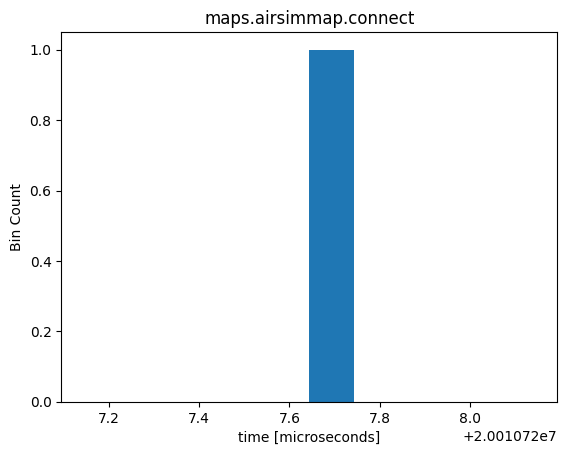

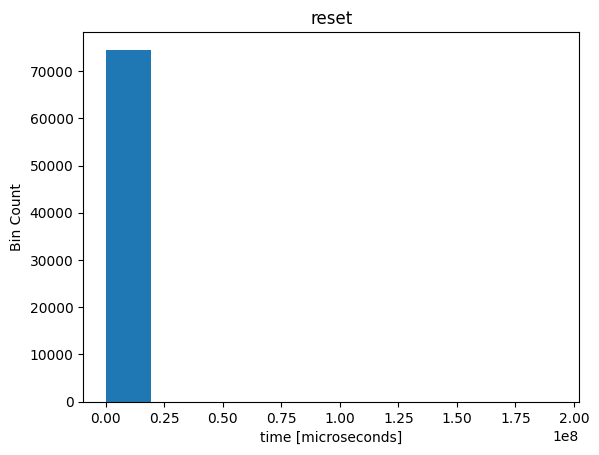

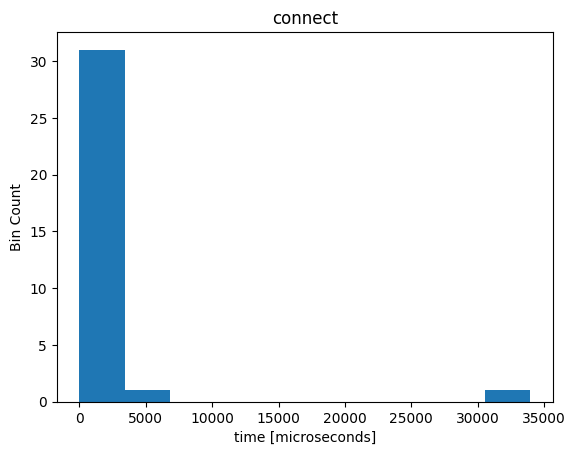

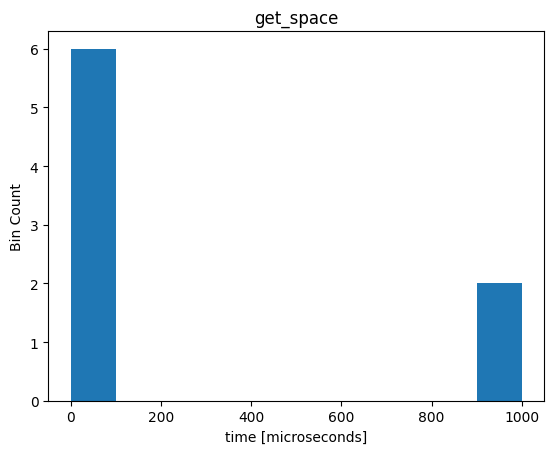

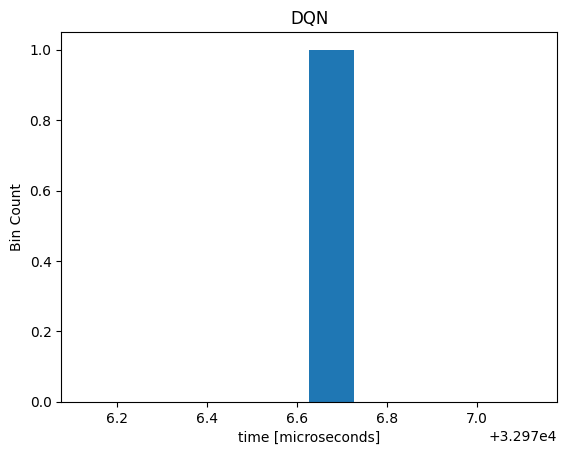

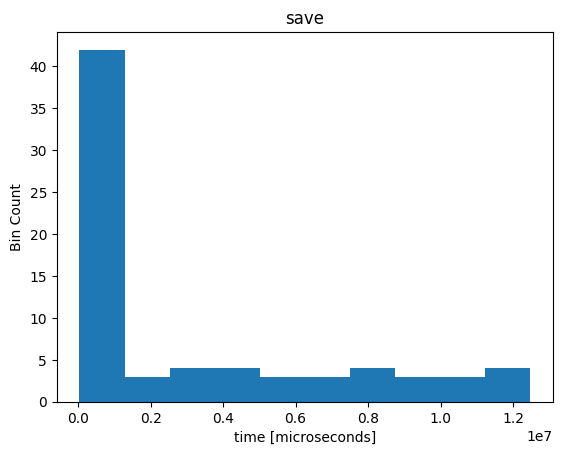

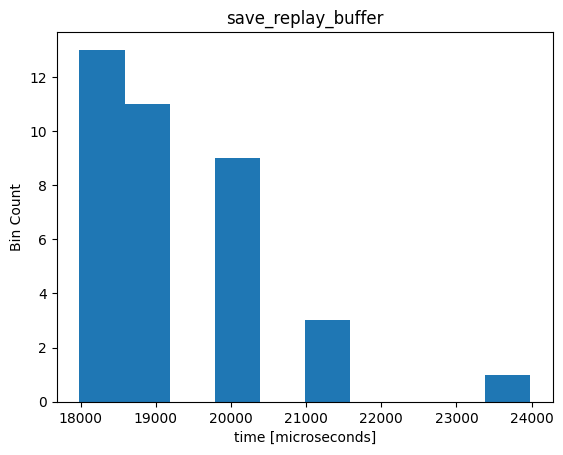

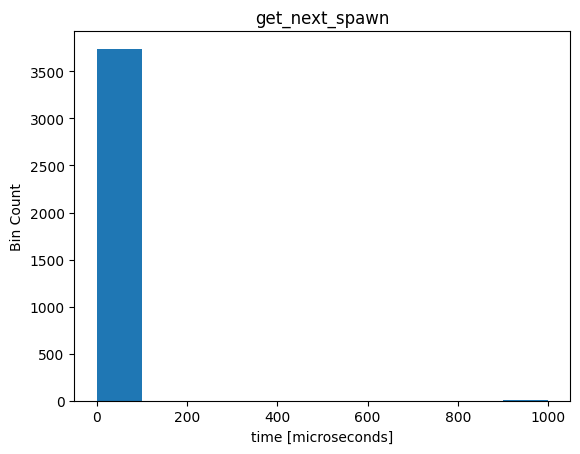

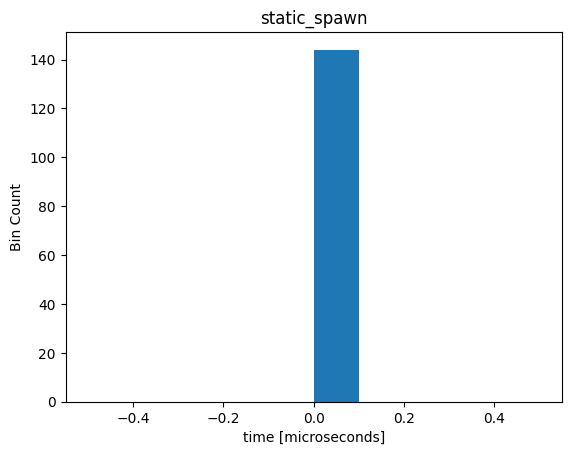

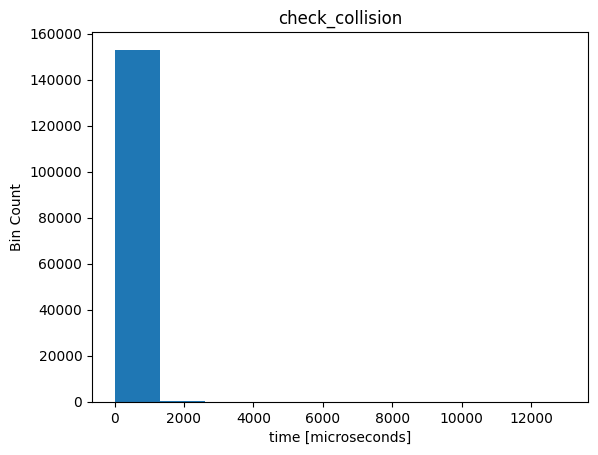

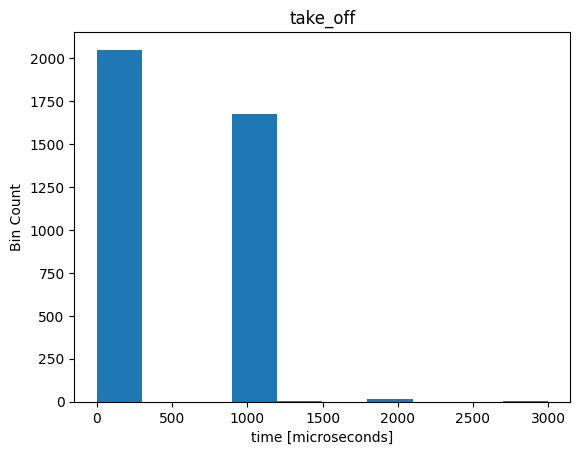

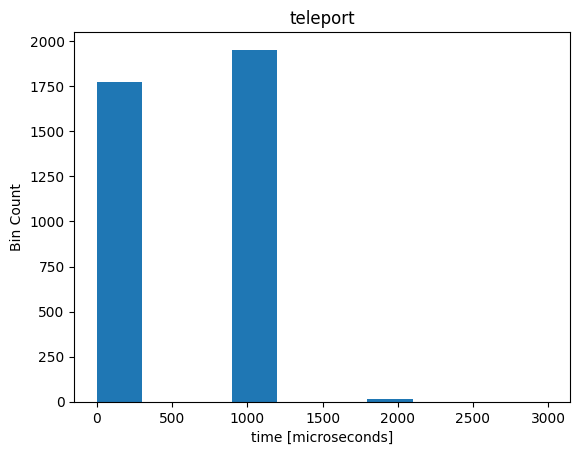

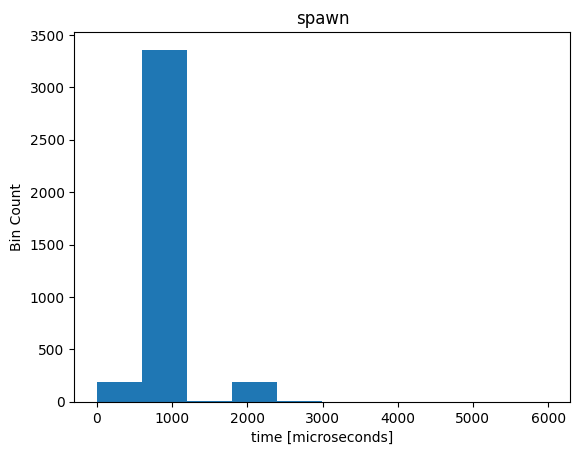

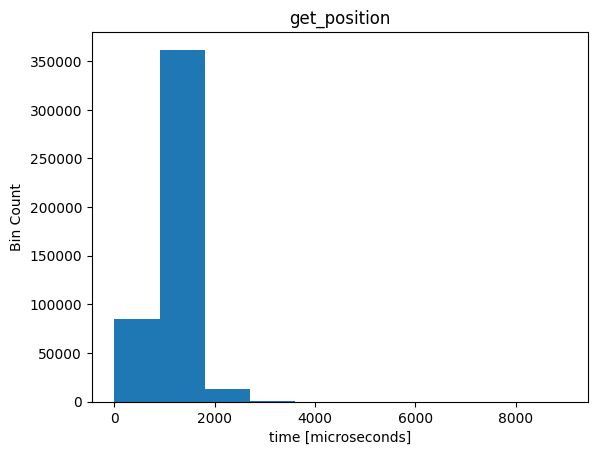

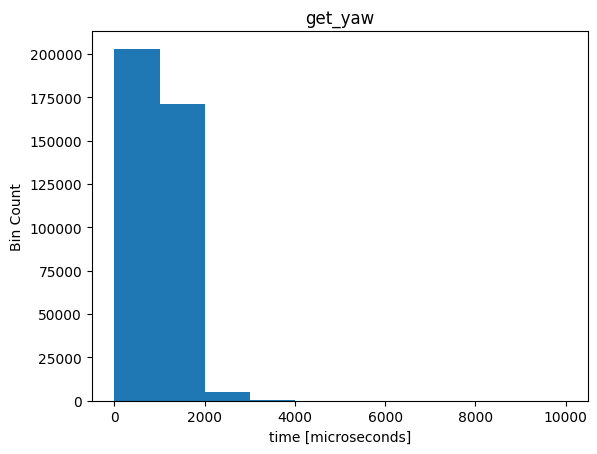

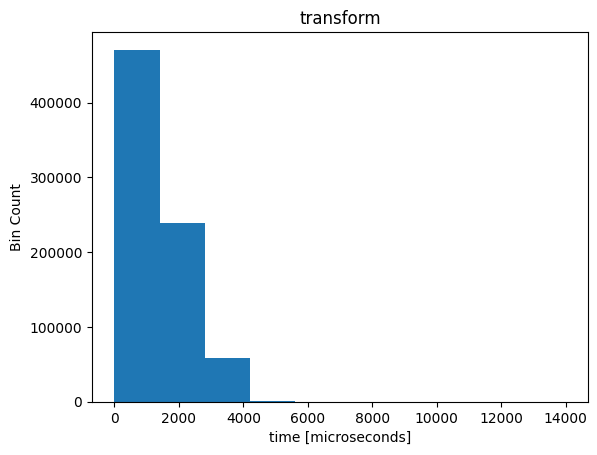

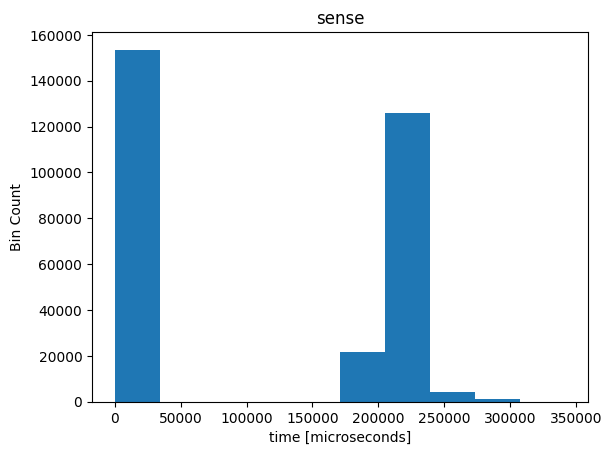

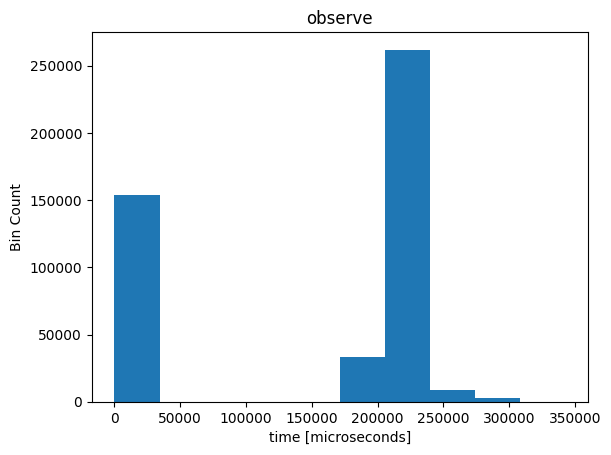

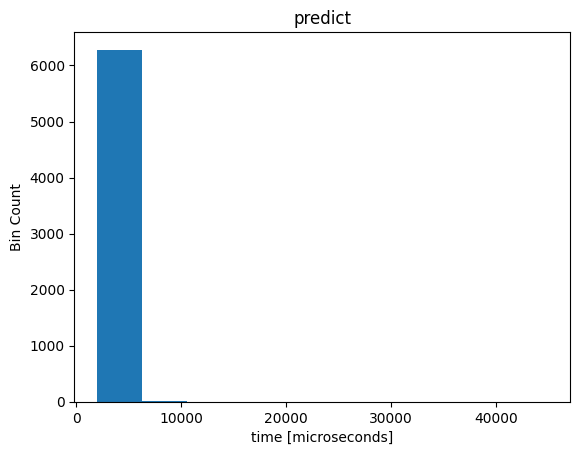

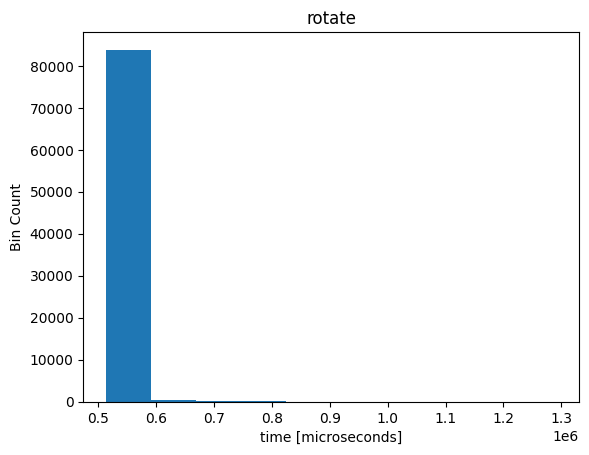

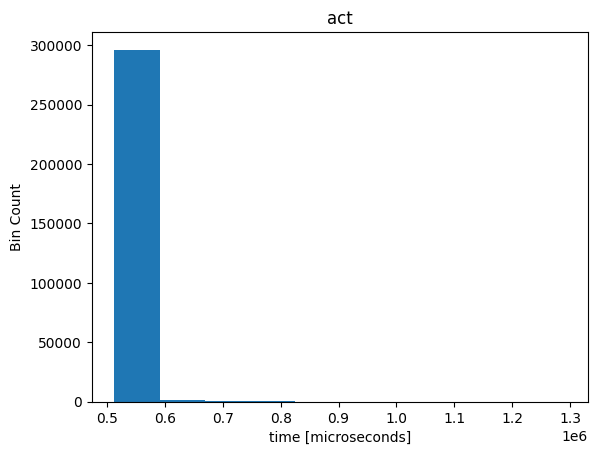

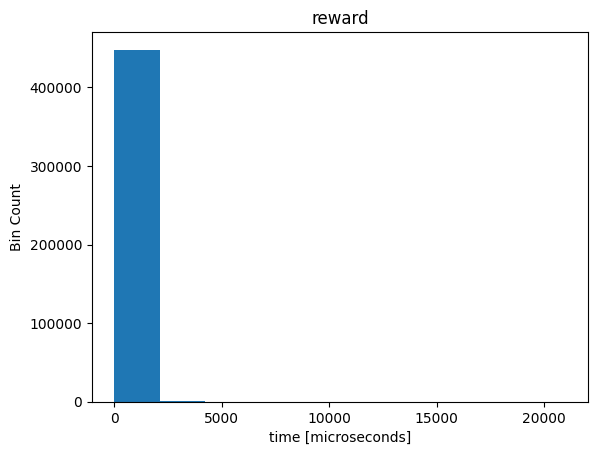

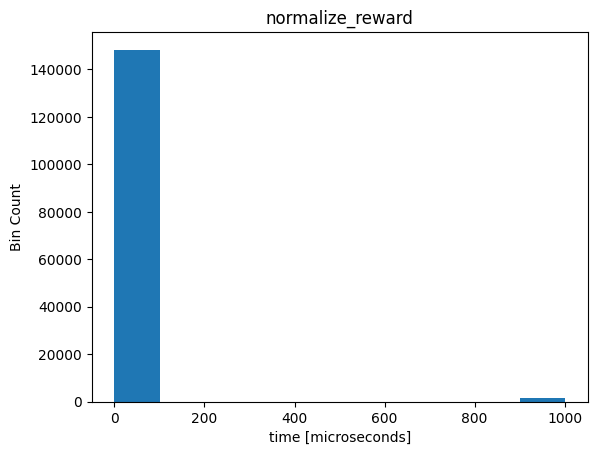

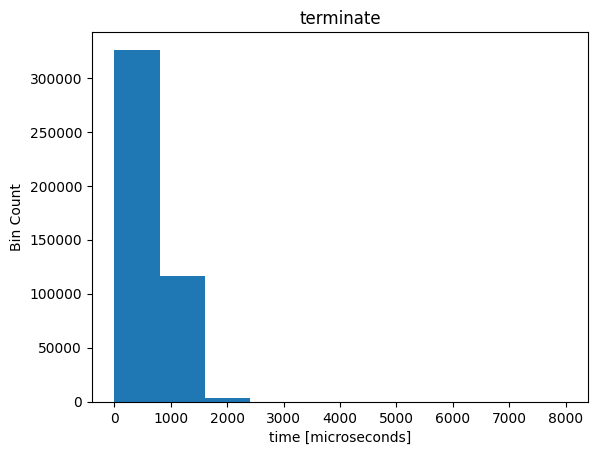

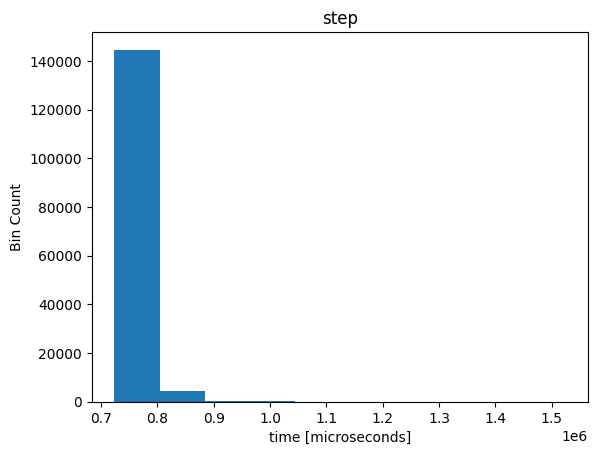

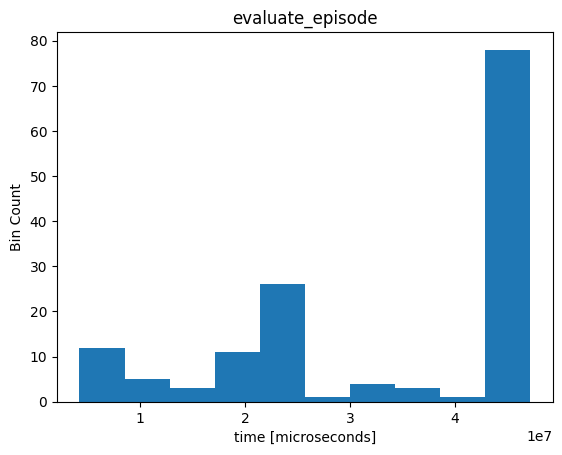

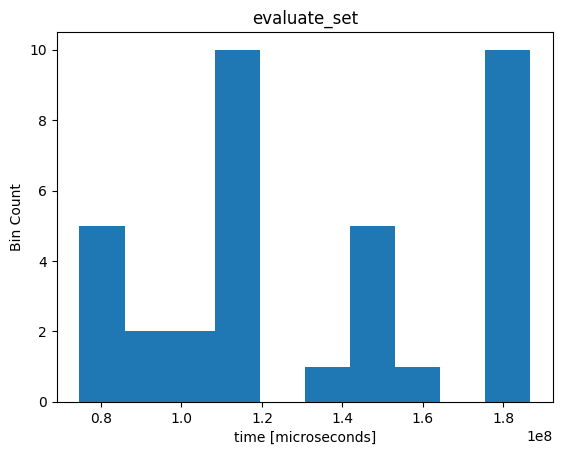

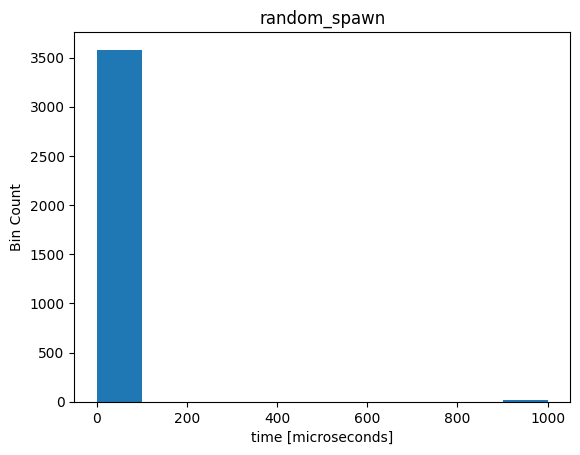

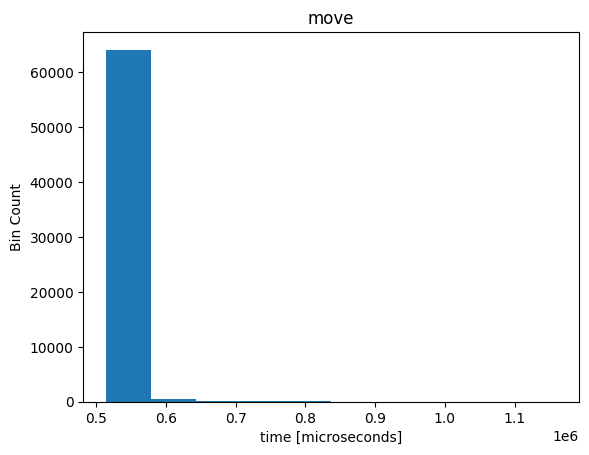

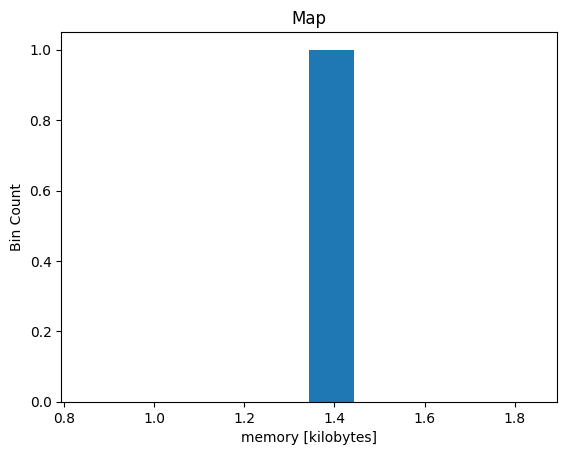

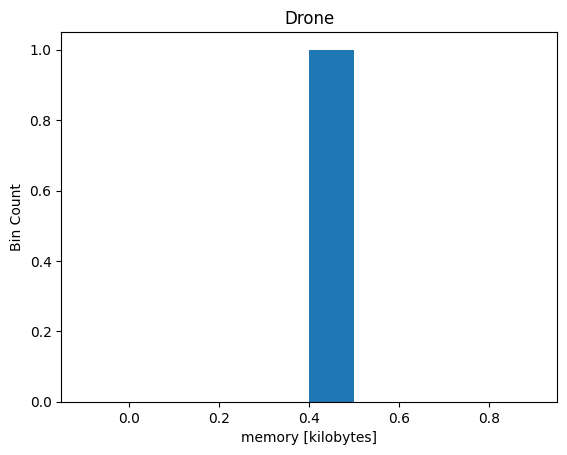

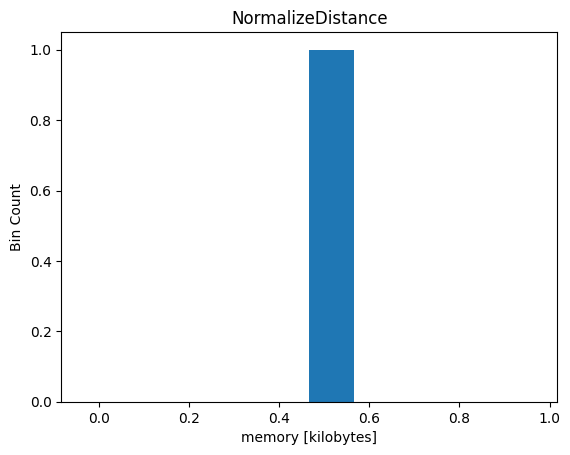

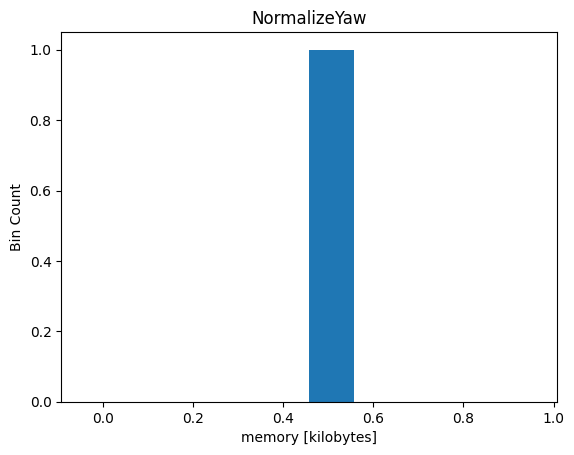

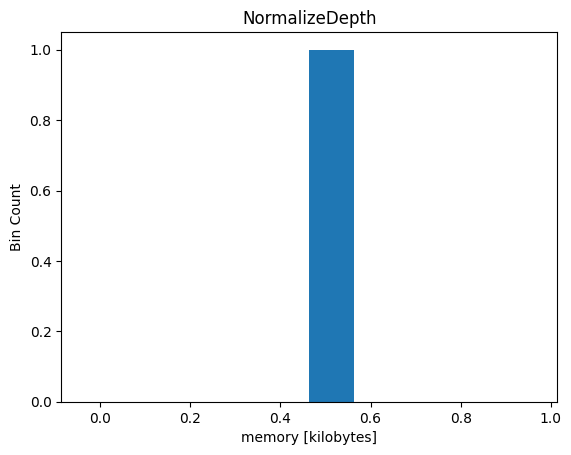

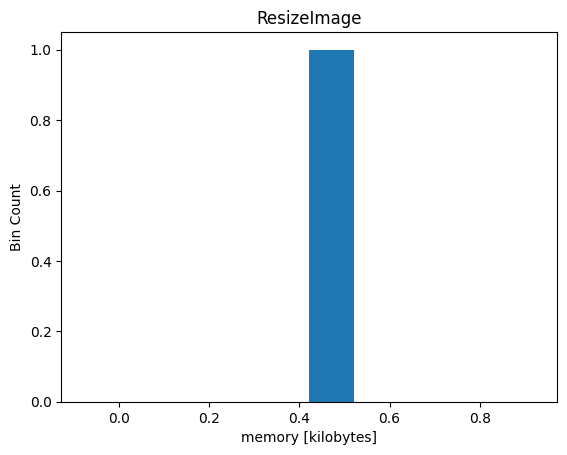

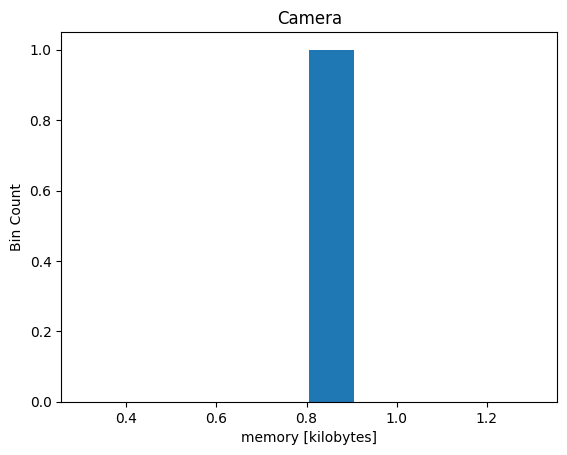

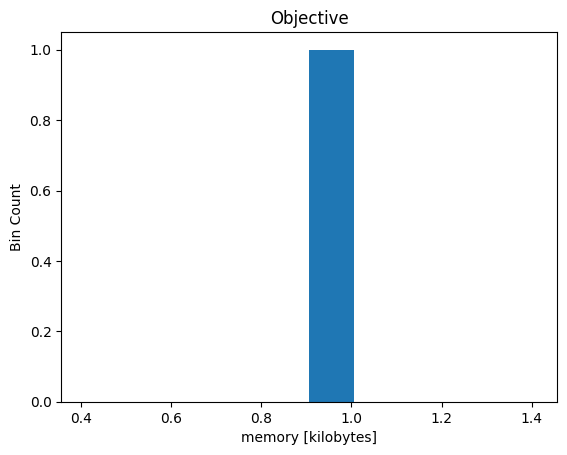

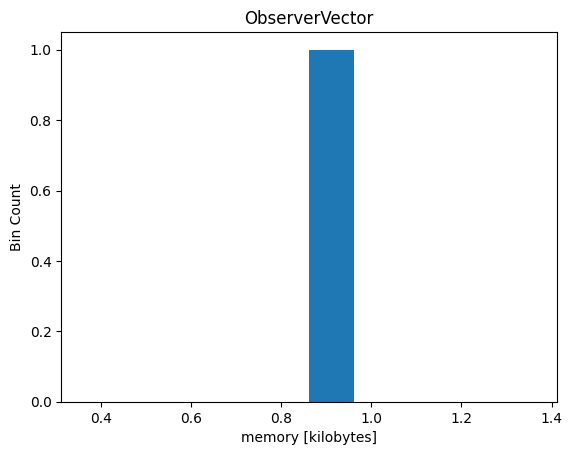

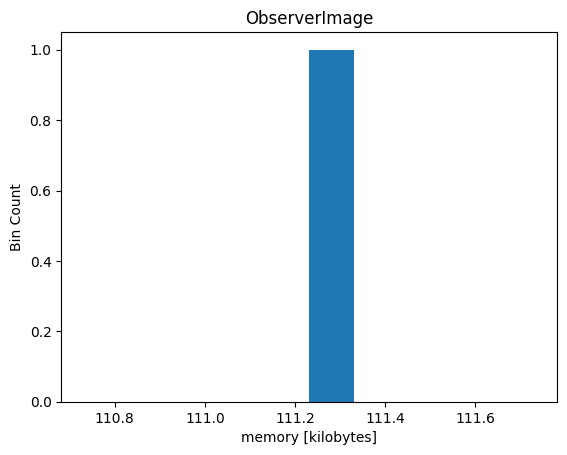

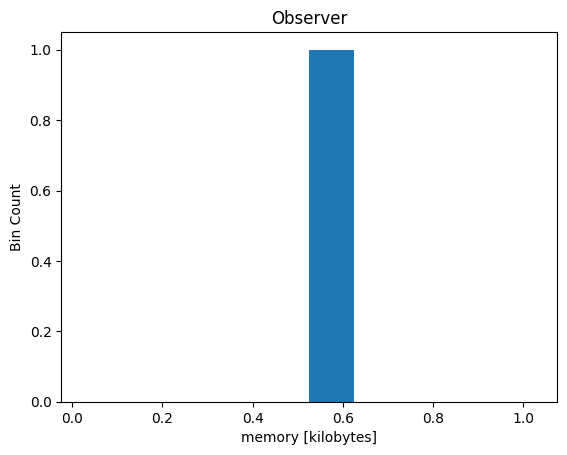

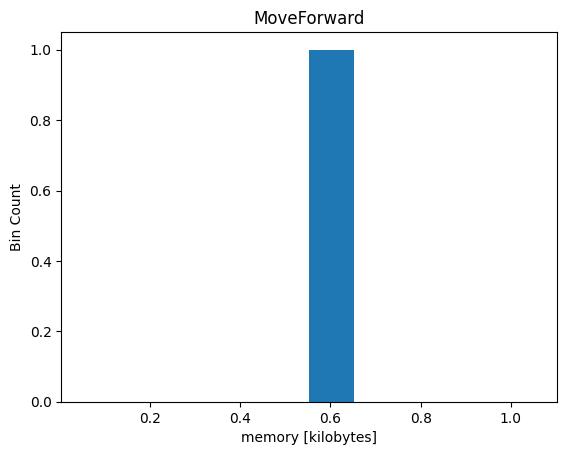

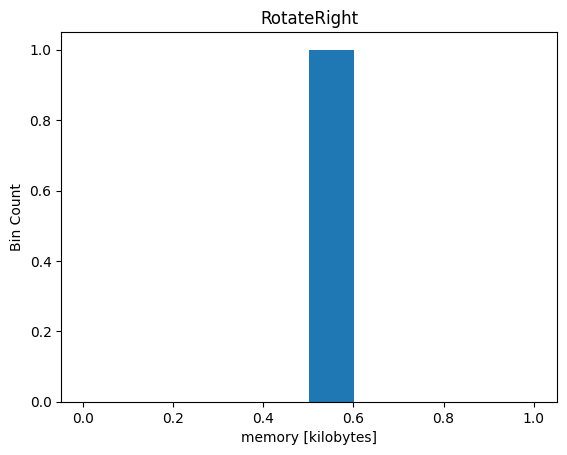

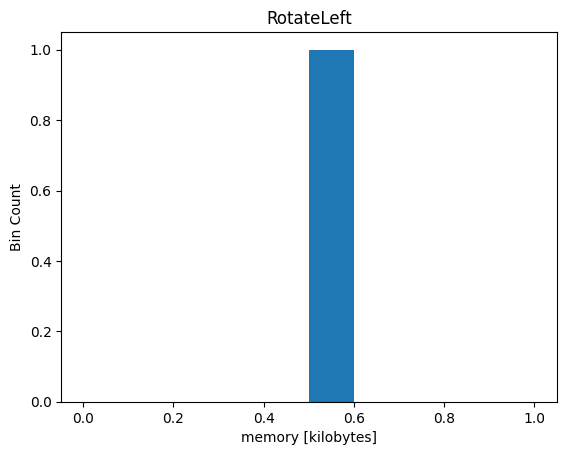

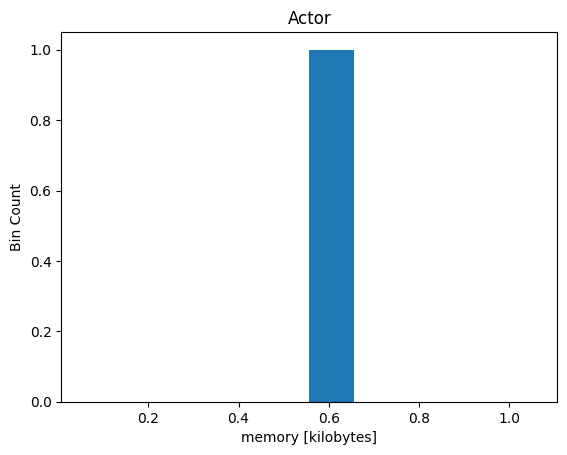

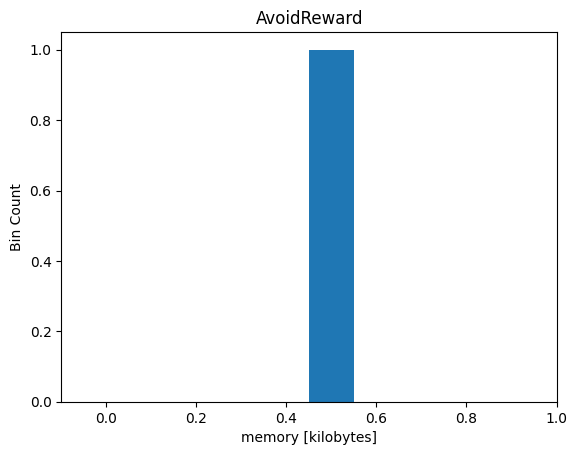

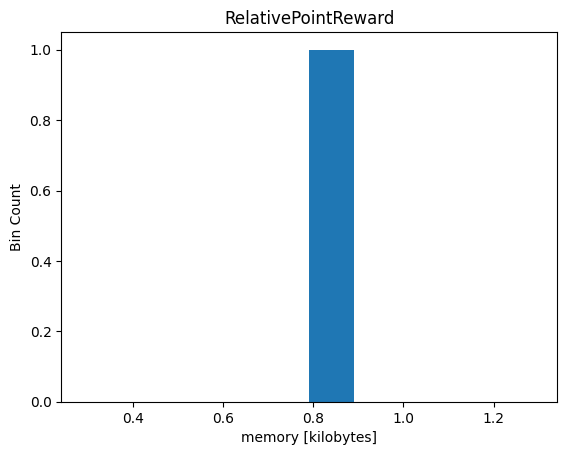

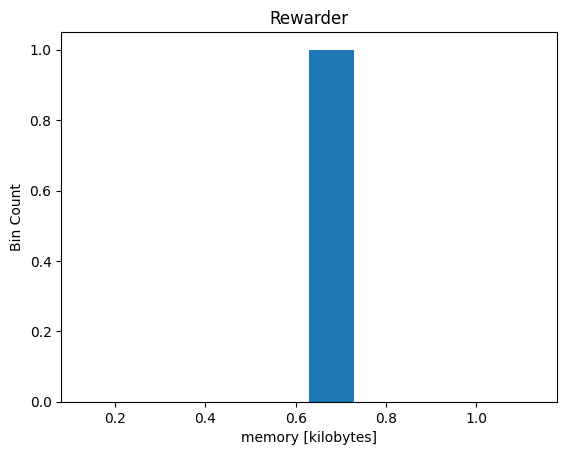

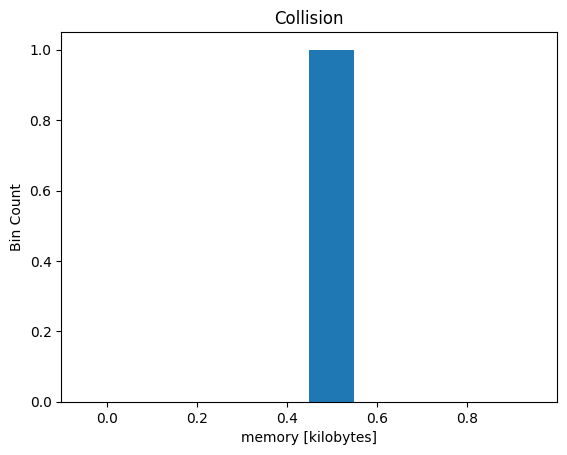

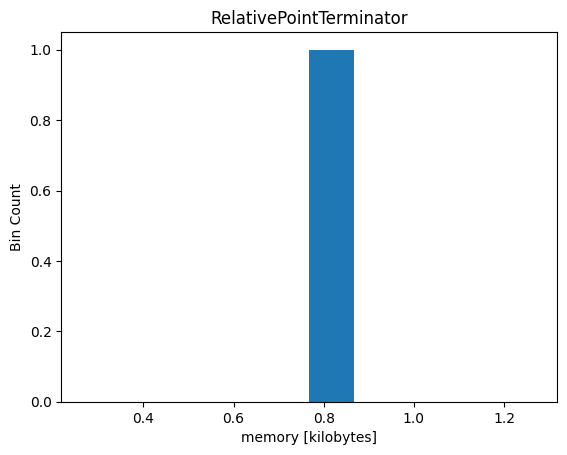

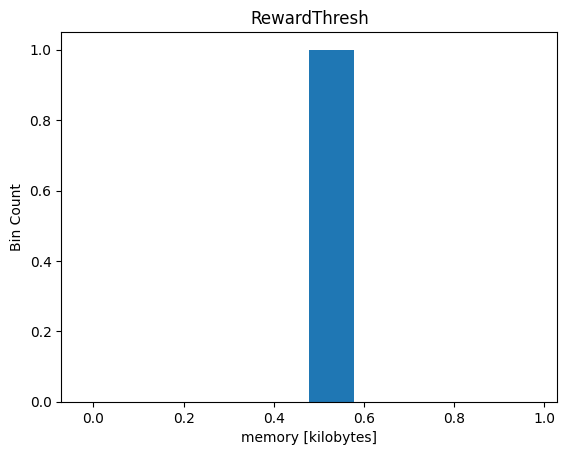

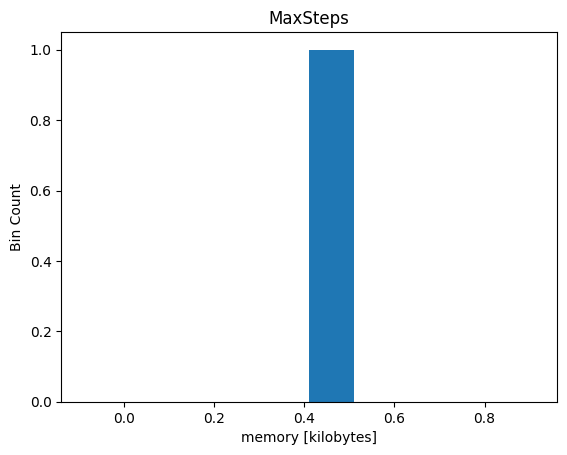

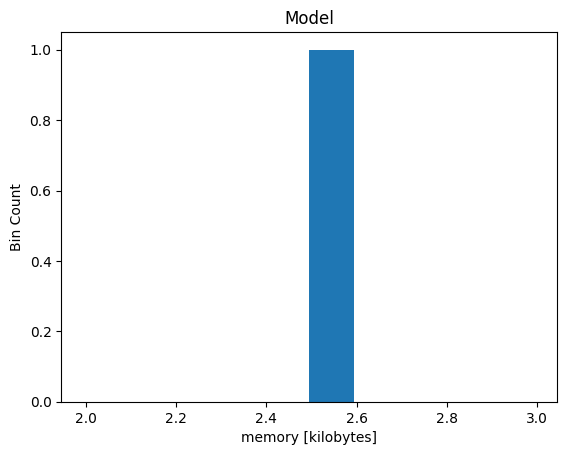

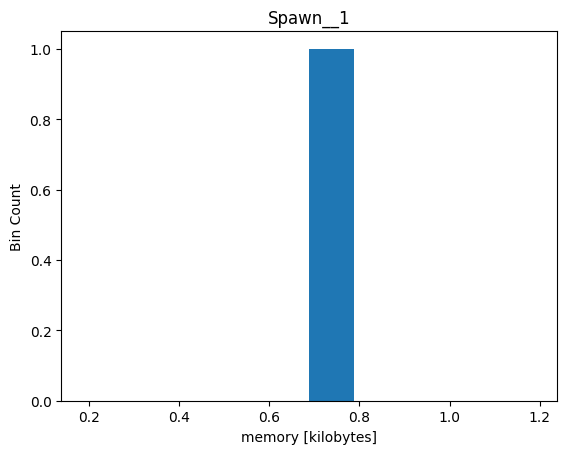

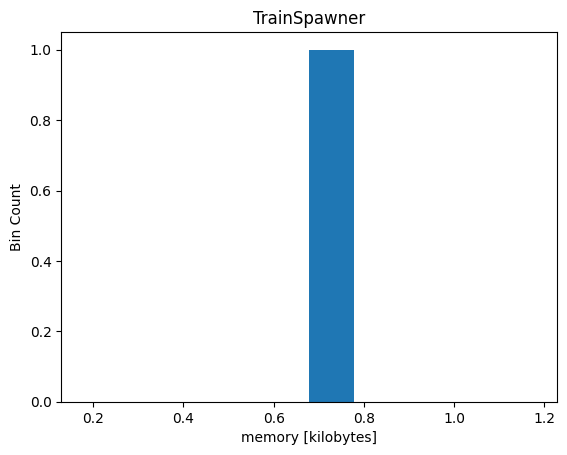

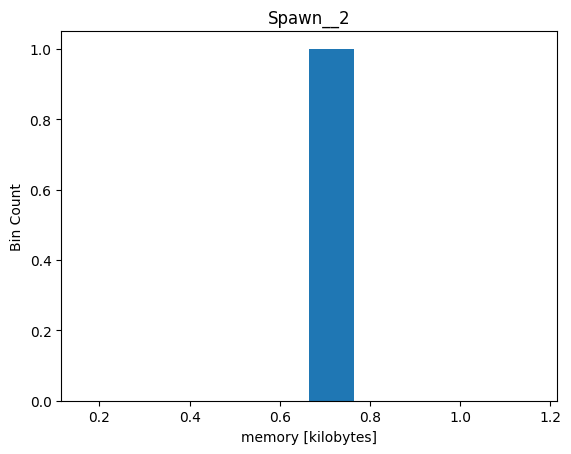

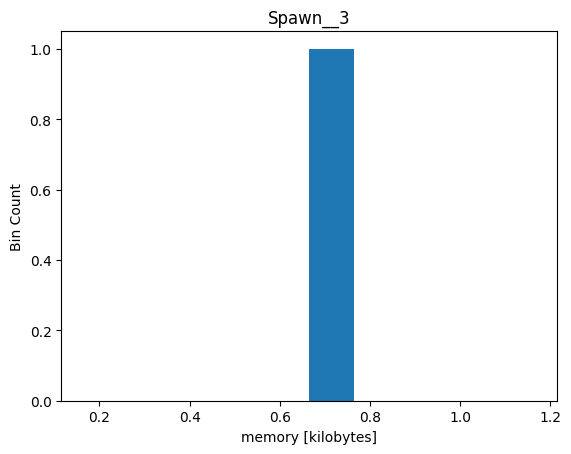

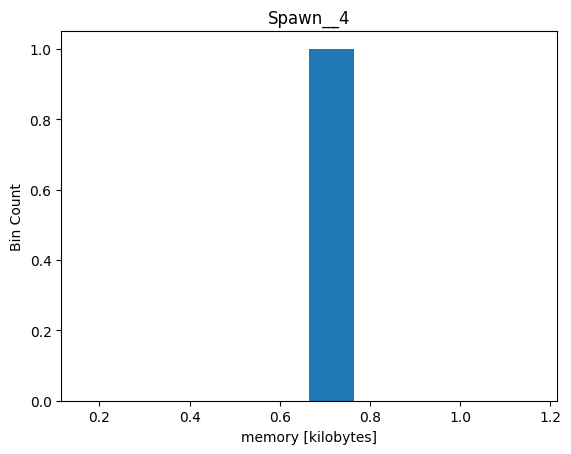

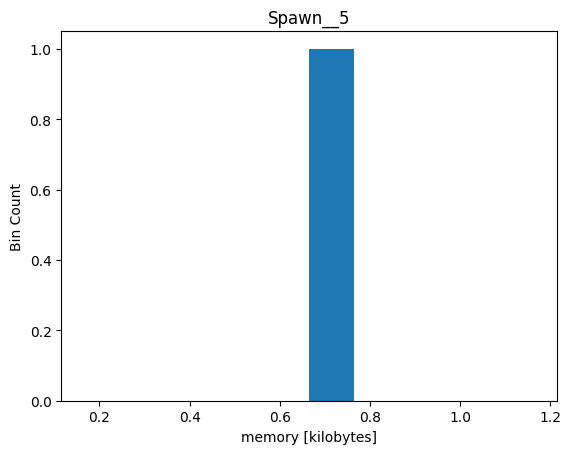

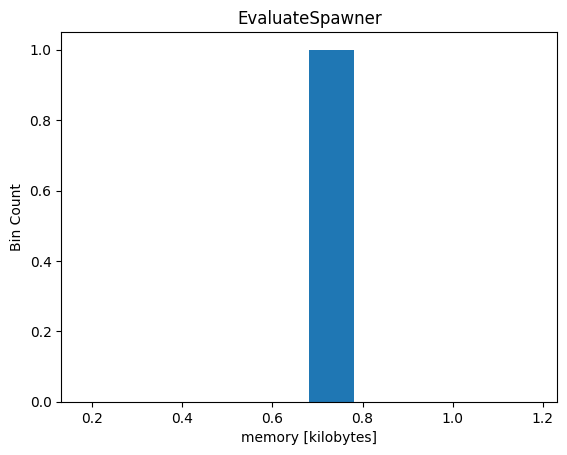

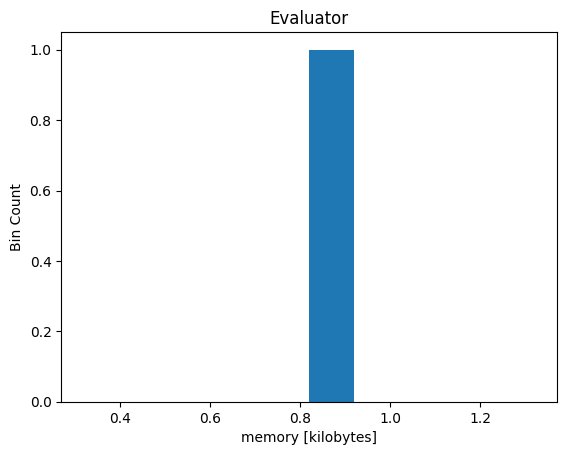

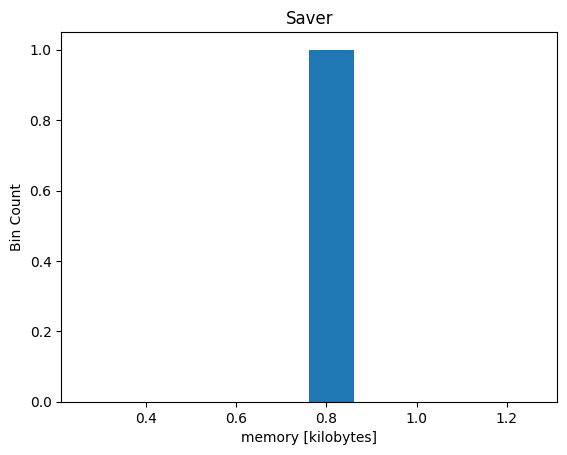

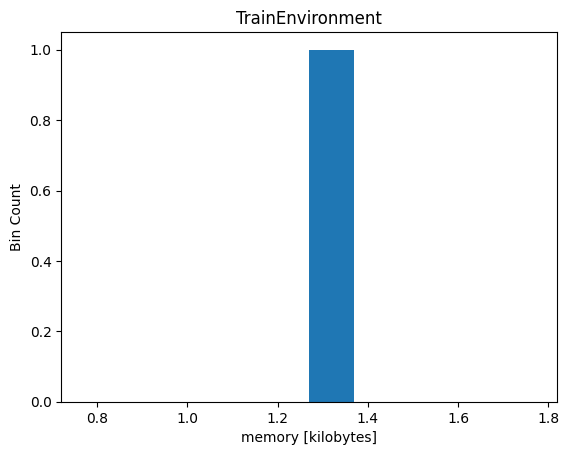

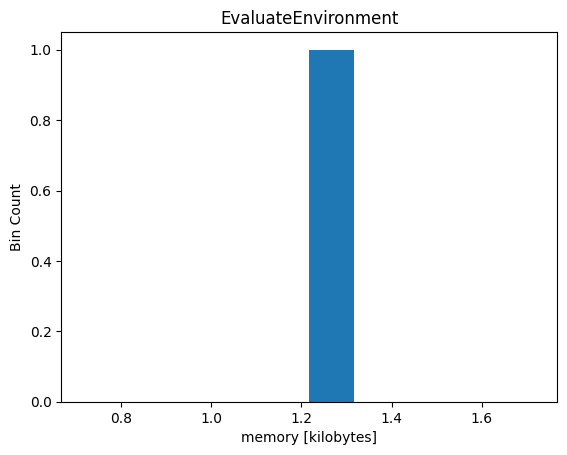

In [49]:
def aggregate_time_benchmarks(benchmarks):
    aggregated = {'units':benchmarks['time']['units']}
    for variable_name in benchmarks['time']:
        if variable_name == 'units':
            continue
        if variable_name in ['maps.airsimmap.connect', ]:
            method_name = variable_name
        else:
            method_name = variable_name.split('.')[-1]
        if method_name not in aggregated:
            aggregated[method_name] = []
        aggregated[method_name] = aggregated[method_name] + benchmarks['time'][variable_name]
    return aggregated
def aggregate_memory_benchmarks(benchmarks):
    aggregated = {'units':benchmarks['memory']['units']}
    for variable_name in benchmarks['memory']:
        if variable_name == 'units':
            continue
        class_name = variable_name.split('_')[0]
        if class_name not in aggregated:
            aggregated[class_name] = []
        aggregated[class_name] = aggregated[class_name] + benchmarks['memory'][variable_name]
    return aggregated
def visualize_benchmarks(benchmarks):
    for metric_name in benchmarks:
        units = benchmarks[metric_name]['units']
        for variable_name in benchmarks[metric_name]:
            if variable_name in ['units', 'memory']:
                continue
            measurements = benchmarks[metric_name][variable_name]
            plt.hist(measurements, 10)
            plt.xlabel(metric_name + ' [' + units + ']')
            plt.ylabel('Bin Count')
            plt.title(variable_name)
            plt.show()
benchmarks['time'] = aggregate_time_benchmarks(benchmarks)
#benchmarks['memory'] = aggregate_memory_benchmarks(benchmarks)
visualize_benchmarks(benchmarks)

# BINVOX

In [8]:
#  Copyright (C) 2012 Daniel Maturana
#  This file is part of binvox-rw-py.
#
#  binvox-rw-py is free software: you can redistribute it and/or modify
#  it under the terms of the GNU General Public License as published by
#  the Free Software Foundation, either version 3 of the License, or
#  (at your option) any later version.
#
#  binvox-rw-py is distributed in the hope that it will be useful,
#  but WITHOUT ANY WARRANTY; without even the implied warranty of
#  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#  GNU General Public License for more details.
#
#  You should have received a copy of the GNU General Public License
#  along with binvox-rw-py. If not, see <http://www.gnu.org/licenses/>.
#

"""
Binvox to Numpy and back.
>>> import numpy as np
>>> import binvox_rw
>>> with open('chair.binvox', 'rb') as f:
...     m1 = binvox_rw.read_as_3d_array(f)
...
>>> m1.dims
[32, 32, 32]
>>> m1.scale
41.133000000000003
>>> m1.translate
[0.0, 0.0, 0.0]
>>> with open('chair_out.binvox', 'wb') as f:
...     m1.write(f)
...
>>> with open('chair_out.binvox', 'rb') as f:
...     m2 = binvox_rw.read_as_3d_array(f)
...
>>> m1.dims==m2.dims
True
>>> m1.scale==m2.scale
True
>>> m1.translate==m2.translate
True
>>> np.all(m1.data==m2.data)
True
>>> with open('chair.binvox', 'rb') as f:
...     md = binvox_rw.read_as_3d_array(f)
...
>>> with open('chair.binvox', 'rb') as f:
...     ms = binvox_rw.read_as_coord_array(f)
...
>>> data_ds = binvox_rw.dense_to_sparse(md.data)
>>> data_sd = binvox_rw.sparse_to_dense(ms.data, 32)
>>> np.all(data_sd==md.data)
True
>>> # the ordering of elements returned by numpy.nonzero changes with axis
>>> # ordering, so to compare for equality we first lexically sort the voxels.
>>> np.all(ms.data[:, np.lexsort(ms.data)] == data_ds[:, np.lexsort(data_ds)])
True
"""

import numpy as np

class Voxels(object):
    """ Holds a binvox model.
    data is either a three-dimensional numpy boolean array (dense representation)
    or a two-dimensional numpy float array (coordinate representation).
    dims, translate and scale are the model metadata.
    dims are the voxel dimensions, e.g. [32, 32, 32] for a 32x32x32 model.
    scale and translate relate the voxels to the original model coordinates.
    To translate voxel coordinates i, j, k to original coordinates x, y, z:
    x_n = (i+.5)/dims[0]
    y_n = (j+.5)/dims[1]
    z_n = (k+.5)/dims[2]
    x = scale*x_n + translate[0]
    y = scale*y_n + translate[1]
    z = scale*z_n + translate[2]
    """

    def __init__(self, data, dims, translate, scale, axis_order):
        self.data = data
        self.dims = dims
        self.translate = translate
        self.scale = scale
        assert (axis_order in ('xzy', 'xyz'))
        self.axis_order = axis_order

    def clone(self):
        data = self.data.copy()
        dims = self.dims[:]
        translate = self.translate[:]
        return Voxels(data, dims, translate, self.scale, self.axis_order)

    def write(self, fp):
        write(self, fp)

def read_header(fp):
    """ Read binvox header. Mostly meant for internal use.
    """
    line = fp.readline().strip()
    if not line.startswith(b'#binvox'):
        raise IOError('Not a binvox file')
    dims = list(map(int, fp.readline().strip().split(b' ')[1:]))
    translate = list(map(float, fp.readline().strip().split(b' ')[1:]))
    scale = list(map(float, fp.readline().strip().split(b' ')[1:]))[0]
    line = fp.readline()
    return dims, translate, scale

def read_as_3d_array(fp, fix_coords=True):
    """ Read binary binvox format as array.
    Returns the model with accompanying metadata.
    Voxels are stored in a three-dimensional numpy array, which is simple and
    direct, but may use a lot of memory for large models. (Storage requirements
    are 8*(d^3) bytes, where d is the dimensions of the binvox model. Numpy
    boolean arrays use a byte per element).
    Doesn't do any checks on input except for the '#binvox' line.
    """
    dims, translate, scale = read_header(fp)
    raw_data = np.frombuffer(fp.read(), dtype=np.uint8)
    # if just using reshape() on the raw data:
    # indexing the array as array[i,j,k], the indices map into the
    # coords as:
    # i -> x
    # j -> z
    # k -> y
    # if fix_coords is true, then data is rearranged so that
    # mapping is
    # i -> x
    # j -> y
    # k -> z
    values, counts = raw_data[::2], raw_data[1::2]
    data = np.repeat(values, counts).astype(np.bool)
    data = data.reshape(dims)
    if fix_coords:
        # xzy to xyz TODO the right thing
        data = np.transpose(data, (0, 2, 1))
        axis_order = 'xyz'
    else:
        axis_order = 'xzy'
    return Voxels(data, dims, translate, scale, axis_order)

def read_as_coord_array(fp, fix_coords=True):
    """ Read binary binvox format as coordinates.
    Returns binvox model with voxels in a "coordinate" representation, i.e.  an
    3 x N array where N is the number of nonzero voxels. Each column
    corresponds to a nonzero voxel and the 3 rows are the (x, z, y) coordinates
    of the voxel.  (The odd ordering is due to the way binvox format lays out
    data).  Note that coordinates refer to the binvox voxels, without any
    scaling or translation.
    Use this to save memory if your model is very sparse (mostly empty).
    Doesn't do any checks on input except for the '#binvox' line.
    """
    dims, translate, scale = read_header(fp)
    raw_data = np.frombuffer(fp.read(), dtype=np.uint8)

    values, counts = raw_data[::2], raw_data[1::2]

    sz = np.prod(dims)
    index, end_index = 0, 0
    end_indices = np.cumsum(counts)
    indices = np.concatenate(([0], end_indices[:-1])).astype(end_indices.dtype)

    values = values.astype(np.bool)
    indices = indices[values]
    end_indices = end_indices[values]

    nz_voxels = []
    for index, end_index in zip(indices, end_indices):
        nz_voxels.extend(range(index, end_index))
    nz_voxels = np.array(nz_voxels)
    # TODO are these dims correct?
    # according to docs,
    # index = x * wxh + z * width + y; // wxh = width * height = d * d

    x = nz_voxels / (dims[0]*dims[1])
    zwpy = nz_voxels % (dims[0]*dims[1]) # z*w + y
    z = zwpy / dims[0]
    y = zwpy % dims[0]
    if fix_coords:
        data = np.vstack((x, y, z))
        axis_order = 'xyz'
    else:
        data = np.vstack((x, z, y))
        axis_order = 'xzy'

    #return Voxels(data, dims, translate, scale, axis_order)
    return Voxels(np.ascontiguousarray(data), dims, translate, scale, axis_order)

def dense_to_sparse(voxel_data, dtype=np.int):
    """ From dense representation to sparse (coordinate) representation.
    No coordinate reordering.
    """
    if voxel_data.ndim!=3:
        raise ValueError('voxel_data is wrong shape; should be 3D array.')
    return np.asarray(np.nonzero(voxel_data), dtype)

def sparse_to_dense(voxel_data, dims, dtype=np.bool):
    if voxel_data.ndim!=2 or voxel_data.shape[0]!=3:
        raise ValueError('voxel_data is wrong shape; should be 3xN array.')
    if np.isscalar(dims):
        dims = [dims]*3
    dims = np.atleast_2d(dims).T
    # truncate to integers
    xyz = voxel_data.astype(np.int)
    # discard voxels that fall outside dims
    valid_ix = ~np.any((xyz < 0) | (xyz >= dims), 0)
    xyz = xyz[:,valid_ix]
    out = np.zeros(dims.flatten(), dtype=dtype)
    out[tuple(xyz)] = True
    return out

#def get_linear_index(x, y, z, dims):
    #""" Assuming xzy order. (y increasing fastest.
    #TODO ensure this is right when dims are not all same
    #"""
    #return x*(dims[1]*dims[2]) + z*dims[1] + y

def write(voxel_model, fp):
    """ Write binary binvox format.
    Note that when saving a model in sparse (coordinate) format, it is first
    converted to dense format.
    Doesn't check if the model is 'sane'.
    """
    if voxel_model.data.ndim==2:
        # TODO avoid conversion to dense
        dense_voxel_data = sparse_to_dense(voxel_model.data, voxel_model.dims)
    else:
        dense_voxel_data = voxel_model.data

    fp.write('#binvox 1\n')
    fp.write('dim '+' '.join(map(str, voxel_model.dims))+'\n')
    fp.write('translate '+' '.join(map(str, voxel_model.translate))+'\n')
    fp.write('scale '+str(voxel_model.scale)+'\n')
    fp.write('data\n')
    if not voxel_model.axis_order in ('xzy', 'xyz'):
        raise ValueError('Unsupported voxel model axis order')

    if voxel_model.axis_order=='xzy':
        voxels_flat = dense_voxel_data.flatten()
    elif voxel_model.axis_order=='xyz':
        voxels_flat = np.transpose(dense_voxel_data, (0, 2, 1)).flatten()

    # keep a sort of state machine for writing run length encoding
    state = voxels_flat[0]
    ctr = 0
    for c in voxels_flat:
        if c==state:
            ctr += 1
            # if ctr hits max, dump
            if ctr==255:
                fp.write(chr(state))
                fp.write(chr(ctr))
                ctr = 0
        else:
            # if switch state, dump
            fp.write(chr(state))
            fp.write(chr(ctr))
            state = c
            ctr = 1
    # flush out remainders
    if ctr > 0:
        fp.write(chr(state))
        fp.write(chr(ctr))

if __name__ == '__main__':
    import doctest
    doctest.testmod()

**********************************************************************
File "__main__", line 5, in __main__
Failed example:
    import binvox_rw
Exception raised:
    Traceback (most recent call last):
      File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2032.0_x64__qbz5n2kfra8p0\lib\doctest.py", line 1350, in __run
        exec(compile(example.source, filename, "single",
      File "<doctest __main__[1]>", line 1, in <module>
        import binvox_rw
    ModuleNotFoundError: No module named 'binvox_rw'
**********************************************************************
File "__main__", line 6, in __main__
Failed example:
    with open('chair.binvox', 'rb') as f:
        m1 = binvox_rw.read_as_3d_array(f)
Exception raised:
    Traceback (most recent call last):
      File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2032.0_x64__qbz5n2kfra8p0\lib\doctest.py", line 1350, in __run
        exec(compile(example.source, filename, "s

C:\Users\timkj\AppData\Local\Temp\ipykernel_12120\2163019709.py:188: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def dense_to_sparse(voxel_data, dtype=np.int):
C:\Users\timkj\AppData\Local\Temp\ipykernel_12120\2163019709.py:196: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org

In [ ]:
with open('maps/voxels/blocks_200_200_100_1.binvox', 'rb') as f:
    m1 = read_as_3d_array(f)
with open('maps/voxels/blocks_200_200_100_p5.binvox', 'rb') as f:
    m2 = read_as_3d_array(f)
with open('maps/voxels/blocks_100_100_50_1.binvox', 'rb') as f:
    m3 = read_as_3d_array(f)
with open('maps/voxels/blocks_100_100_50_p5.binvox', 'rb') as f:
    m4 = read_as_3d_array(f)

In [33]:
m4.dims

[200, 100, 200]

In [32]:
m4.translate

[-50.0, -50.0, -25.0]

In [31]:
m4.scale

0.01

In [29]:
m4.data.shape

(200, 200, 100)

In [39]:
m=m2
x = 0*m.scale + m.translate[0]
y = 0*m.scale + m.translate[1]
z = 0*m.scale + m.translate[2]

print(x,y,z)

-100.0 -100.0 -50.0


In [12]:
fp.readline()

b'scale 0.005\n'

In [ ]:
line = fp.readline().strip()
if not line.startswith(b'#binvox'):
    raise IOError('Not a binvox file')
dims = list(map(int, fp.readline().strip().split(b' ')[1:]))
translate = list(map(float, fp.readline().strip().split(b' ')[1:]))
scale = list(map(float, fp.readline().strip().split(b' ')[1:]))[0]
line = fp.readline()

C:\Users\timkj\AppData\Local\Temp\ipykernel_8468\2163019709.py:131: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.repeat(values, counts).astype(np.bool)


In [25]:
m1.dims

[200, 100, 200]

In [26]:
m1.scale

0.005

C:\Users\timkj\AppData\Local\Temp\ipykernel_8468\2163019709.py:131: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.repeat(values, counts).astype(np.bool)


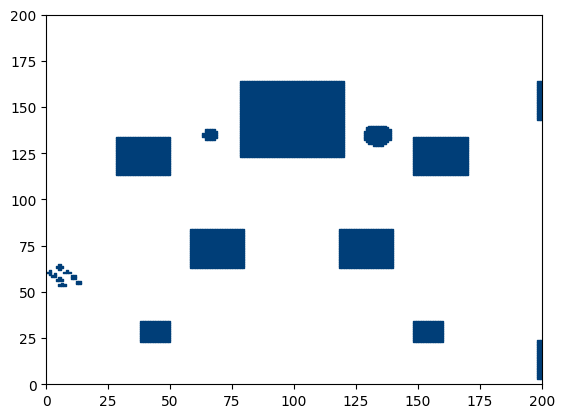

In [27]:
plot_map()
plt.xlim([0, 200])
plt.ylim([0, 200])
plt.show()

In [29]:
x = 100
y = 150
for z in range(m1.data.shape[2]):
    print(x, y, z, m1.data[x, y, z])

100 150 0 False
100 150 1 False
100 150 2 False
100 150 3 False
100 150 4 False
100 150 5 False
100 150 6 False
100 150 7 False
100 150 8 False
100 150 9 False
100 150 10 False
100 150 11 False
100 150 12 False
100 150 13 False
100 150 14 False
100 150 15 False
100 150 16 False
100 150 17 False
100 150 18 False
100 150 19 False
100 150 20 False
100 150 21 False
100 150 22 False
100 150 23 False
100 150 24 False
100 150 25 False
100 150 26 False
100 150 27 False
100 150 28 False
100 150 29 False
100 150 30 False
100 150 31 False
100 150 32 False
100 150 33 False
100 150 34 False
100 150 35 False
100 150 36 False
100 150 37 False
100 150 38 False
100 150 39 False
100 150 40 False
100 150 41 False
100 150 42 False
100 150 43 False
100 150 44 False
100 150 45 False
100 150 46 False
100 150 47 True
100 150 48 True
100 150 49 True
100 150 50 False
100 150 51 False
100 150 52 False
100 150 53 False
100 150 54 True
100 150 55 True
100 150 56 True
100 150 57 True
100 150 58 True
100 150 59 True

In [9]:
def plot_map(object_color=uci_blue):
    with open('resources/voxel_grids/blocksmap.binvox', 'rb') as f:
        m1 = read_as_3d_array(f)
    origin = m1.data[int(m1.data.shape[1]/2), int(m1.data.shape[0]/2), :]
    floor_dim = max([i for i, x in enumerate(origin) if x])
    scale = m1.scale * 100 # off by 100
    shift = 100
    plt_patches = []
    for x in range(m1.data.shape[0]):
        for y in range(m1.data.shape[1]):
            for z in range(m1.data.shape[2]):
                if m1.data[x, y, z] and z > floor_dim:
                    #x_loc = x - shift - scale/2 # align to left for plt.rect
                    #y_loc = y - shift - scale/2 # align to bottom for plt.rect
                    #patch = patches.Rectangle((x_loc, y_loc), scale, scale, color = object_color)
                    patch = patches.Rectangle((x, y), 1, 1, color = object_color)
                    plt_patches.append(patch)
                    break
    # add list of patches (much quicker than iteratively drawing)
    collection = PatchCollection(plt_patches, match_original=True)
    plt.gca().add_collection(collection)

In [105]:
def plot_spawns_goals(
    drone_radius = 0.5,
    goal_tolerance = 4,
    goal_distance = 100,
    spawns = [],
    goals = [],
    spawn_color = color_blinds['red'],
    goal_color = color_blinds['orange'],
    goal_wedge = True,
):
    # patch stuff
    spawn_patches = []
    goal_patches = []
    for idx in range(len(spawns)):
        spawn = spawns[idx]
        goal = goals[idx]
        spawn_patch = patches.Rectangle(
            (spawn[0], spawn[1]), 
            drone_radius, 
            drone_radius, 
            color=spawn_color,
        )
        spawn_patches.append(spawn_patch)
        if goal_wedge:
            radius = math.sqrt(goal[0]**2 + goal[1]**2)
            goal_patch = patches.Wedge(
                (spawn[0], spawn[1]), 
                goal_distance+goal_tolerance, 
                goal[0], goal[1], 
                width=2*goal_tolerance,
                color=goal_color,
            )
        else:
            goal_patch = patches.Circle(
                (goal[0], goal[1]), 
                goal_tolerance, 
                color=goal_color,
            )
        goal_patches.append(goal_patch)
    # add list of patches (much quicker than iteratively drawing)
    spawn_collection = PatchCollection(spawn_patches, match_original=True)
    goal_collection = PatchCollection(goal_patches, match_original=True)
    plt.gca().add_collection(goal_collection)
    plt.gca().add_collection(spawn_collection)

In [106]:
def plot_environment(name='Learning Environment (to scale)'):
    fig = plt.figure()
    fig.set_size_inches((6, 6))
    plt.title(name)
    plt.xlabel('y [meters]')
    plt.ylabel('x [meters]')
    plt.xlim(-120, 120)
    plt.ylim(-120, 120)
    # custom legend hack
    plt.scatter(-999, -999, marker='s', color=object_color)
    plt.scatter(-999, -999, marker='s', color=train_spawn_color)
    plt.scatter(-999, -999, color=train_goal_color)
    plt.scatter(-999, -999, color=eval_spawn_color)
    plt.scatter(-999, -999, color=eval_goal_color)
    plt.legend(['Objects', 'Train Spawn', 'Train Goal', 'Eval Spawn', 'Eval Goal'],
               loc='center left', 
               bbox_to_anchor=(1, 0.5),)

In [107]:
object_color = color_blinds['blue']
train_spawn_color = color_blinds['red']
train_goal_color = color_blinds['orange']
eval_spawn_color = color_blinds['pink']
eval_goal_color = color_blinds['purple']
drone_radius = 0.5
goal_tolerance = 4
goal_distance = 100

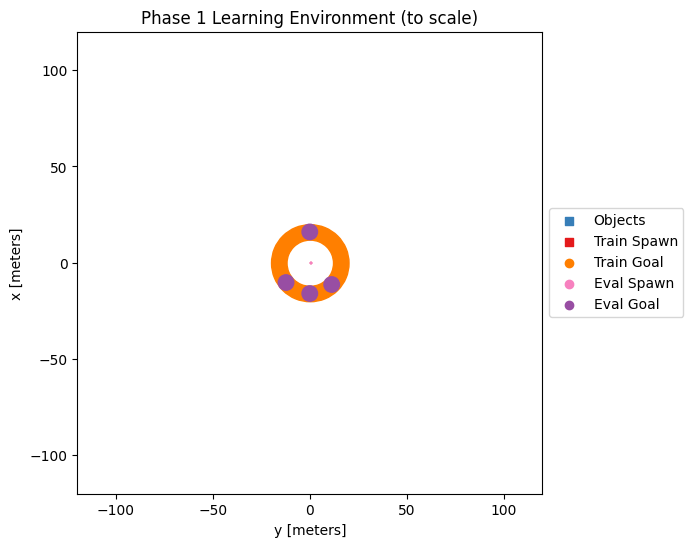

In [108]:
# plot phase 1 environment map
name='Phase 1 Learning Environment (to scale)'
goal_distance = 16

# set training spawns and goals
x_min = 0
x_max = 0
y_min = 0
y_max = 0
yaw_min = 0
yaw_max = 360
training_spawns = []
training_goals = []
for x in np.arange(x_min, x_max + drone_radius, drone_radius):
    for y in np.arange(y_min, y_max + drone_radius, drone_radius):
        training_spawns.append([y, x])
        training_goals.append([yaw_min, yaw_max])
        
# set evaluation spawns and goals
evaluation_vecs = [
    [0,0,0],
    [0,0,math.radians(135)],
    [0,0,math.radians(180)],
    [0,0,math.radians(230)],
]
evaluation_spawns = []
evaluation_goals = []
for eval_vec in evaluation_vecs:
    x = eval_vec[0]
    y = eval_vec[1]
    yaw = eval_vec[2]
    evaluation_spawns.append([y, x])
    goal_x = goal_distance * math.cos(yaw)
    goal_y = goal_distance * math.sin(yaw)
    evaluation_goals.append([goal_y, goal_x])
    
# make plot
plot_environment(name)

# plot training spawns and goals
plot_spawns_goals(
    drone_radius = drone_radius,
    goal_tolerance = goal_tolerance,
    goal_distance = goal_distance,
    spawns = training_spawns,
    goals = training_goals,
    spawn_color = train_spawn_color,
    goal_color = train_goal_color,
    goal_wedge = True,
)

# plot map objects
#plot_map(object_color)

# plot evaluation  spawns and goals
plot_spawns_goals(
    drone_radius = drone_radius,
    goal_tolerance = goal_tolerance,
    goal_distance = goal_distance,
    spawns = evaluation_spawns,
    goals = evaluation_goals,
    spawn_color = eval_spawn_color,
    goal_color = eval_goal_color,
    goal_wedge = False,
)

# show all
plt.show()

C:\Users\timkj\AppData\Local\Temp\ipykernel_11340\2163019709.py:131: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.repeat(values, counts).astype(np.bool)


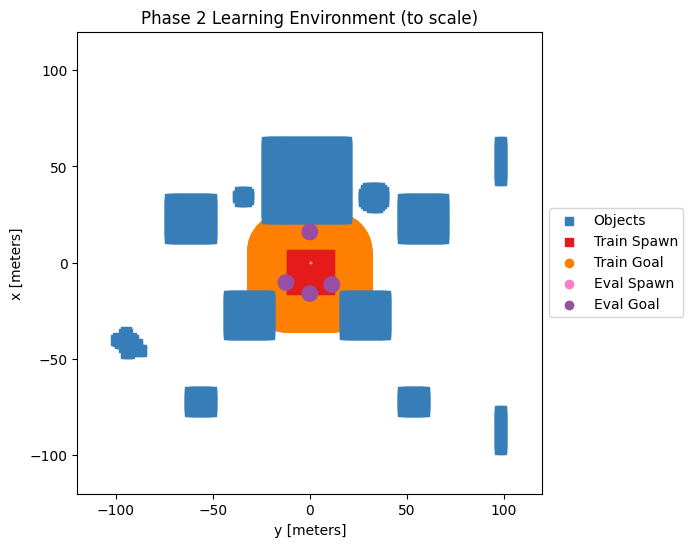

In [109]:
# plot phase 2 environment map
name='Phase 2 Learning Environment (to scale)'
goal_distance = 16

# set training spawns and goals
x_min = -16
x_max = 6
y_min = -12
y_max = 12
yaw_min = 0
yaw_max = 360
training_spawns = []
training_goals = []
for x in np.arange(x_min, x_max + drone_radius, drone_radius):
    for y in np.arange(y_min, y_max + drone_radius, drone_radius):
        training_spawns.append([y, x])
        training_goals.append([yaw_min, yaw_max])
        
# set evaluation spawns and goals
evaluation_vecs = [
    [0,0,math.radians(0)],
    [0,0,math.radians(135)],
    [0,0,math.radians(180)],
    [0,0,math.radians(230)],
]
evaluation_spawns = []
evaluation_goals = []
for eval_vec in evaluation_vecs:
    x = eval_vec[0]
    y = eval_vec[1]
    yaw = eval_vec[2]
    evaluation_spawns.append([y, x])
    goal_x = goal_distance * math.cos(yaw)
    goal_y = goal_distance * math.sin(yaw)
    evaluation_goals.append([goal_y, goal_x])
    
# make plot
plot_environment(name)

# plot training spawns and goals
plot_spawns_goals(
    drone_radius = drone_radius,
    goal_tolerance = goal_tolerance,
    goal_distance = goal_distance,
    spawns = training_spawns,
    goals = training_goals,
    spawn_color = train_spawn_color,
    goal_color = train_goal_color,
    goal_wedge = True,
)

# plot map objects
plot_map(object_color)

# plot evaluation  spawns and goals
plot_spawns_goals(
    drone_radius = drone_radius,
    goal_tolerance = goal_tolerance,
    goal_distance = goal_distance,
    spawns = evaluation_spawns,
    goals = evaluation_goals,
    spawn_color = eval_spawn_color,
    goal_color = eval_goal_color,
    goal_wedge = False,
)

# show all
plt.show()

C:\Users\timkj\AppData\Local\Temp\ipykernel_11340\2163019709.py:131: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.repeat(values, counts).astype(np.bool)


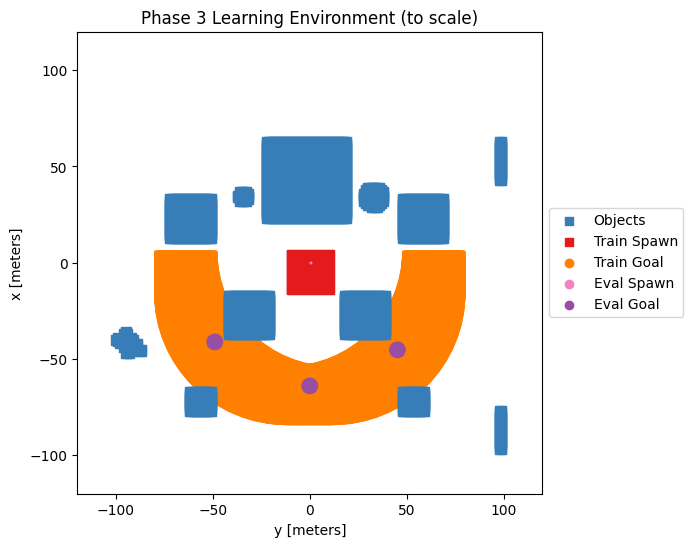

In [113]:
# plot phase 3 environment map
name='Phase 3 Learning Environment (to scale)'
goal_distance = 64

# set training spawns and goals
x_min = -16
x_max = 6
y_min = -12
y_max = 12
yaw_min = 180
yaw_max = 360
training_spawns = []
training_goals = []
for x in np.arange(x_min, x_max + drone_radius, drone_radius):
    for y in np.arange(y_min, y_max + drone_radius, drone_radius):
        training_spawns.append([y, x])
        training_goals.append([yaw_min, yaw_max])
        
# set evaluation spawns and goals
evaluation_vecs = [
    [0,0,math.radians(135)],
    [0,0,math.radians(180)],
    [0,0,math.radians(230)],
]
evaluation_spawns = []
evaluation_goals = []
for eval_vec in evaluation_vecs:
    x = eval_vec[0]
    y = eval_vec[1]
    yaw = eval_vec[2]
    evaluation_spawns.append([y, x])
    goal_x = goal_distance * math.cos(yaw)
    goal_y = goal_distance * math.sin(yaw)
    evaluation_goals.append([goal_y, goal_x])
    
# make plot
plot_environment(name)

# plot training spawns and goals
plot_spawns_goals(
    drone_radius = drone_radius,
    goal_tolerance = goal_tolerance,
    goal_distance = goal_distance,
    spawns = training_spawns,
    goals = training_goals,
    spawn_color = train_spawn_color,
    goal_color = train_goal_color,
    goal_wedge = True,
)

# plot map objects
plot_map(object_color)

# plot evaluation  spawns and goals
plot_spawns_goals(
    drone_radius = drone_radius,
    goal_tolerance = goal_tolerance,
    goal_distance = goal_distance,
    spawns = evaluation_spawns,
    goals = evaluation_goals,
    spawn_color = eval_spawn_color,
    goal_color = eval_goal_color,
    goal_wedge = False,
)

# show all
plt.show()

C:\Users\timkj\AppData\Local\Temp\ipykernel_11340\2163019709.py:131: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.repeat(values, counts).astype(np.bool)


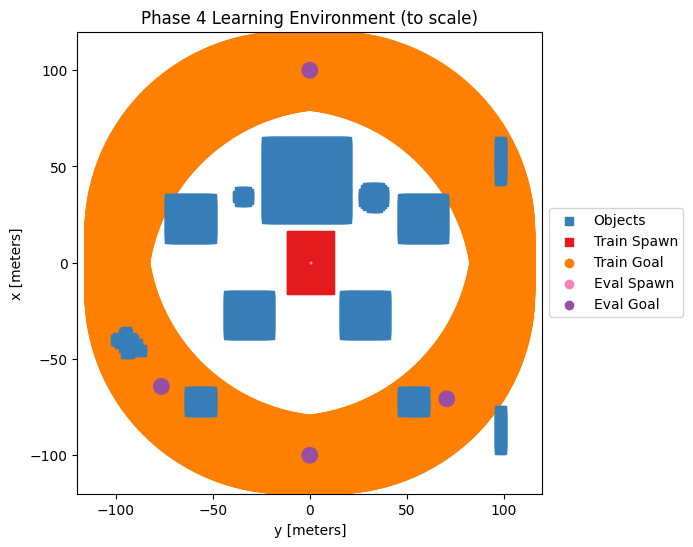

In [115]:
# plot phase 4 environment map
name='Phase 4 Learning Environment (to scale)'
goal_distance = 100

# set training spawns and goals
x_min = -16
x_max = 16
y_min = -12
y_max = 12
yaw_min = 0
yaw_max = 360
training_spawns = []
training_goals = []
for x in np.arange(x_min, x_max + drone_radius, drone_radius):
    for y in np.arange(y_min, y_max + drone_radius, drone_radius):
        training_spawns.append([y, x])
        training_goals.append([yaw_min, yaw_max])
        
# set evaluation spawns and goals
evaluation_vecs = [
    [0,0,0],
    [0,0,math.radians(135)],
    [0,0,math.radians(180)],
    [0,0,math.radians(230)],
]
evaluation_spawns = []
evaluation_goals = []
for eval_vec in evaluation_vecs:
    x = eval_vec[0]
    y = eval_vec[1]
    yaw = eval_vec[2]
    evaluation_spawns.append([y, x])
    goal_x = goal_distance * math.cos(yaw)
    goal_y = goal_distance * math.sin(yaw)
    evaluation_goals.append([goal_y, goal_x])
    
# make plot
plot_environment(name)

# plot training spawns and goals
plot_spawns_goals(
    drone_radius = drone_radius,
    goal_tolerance = goal_tolerance,
    goal_distance = goal_distance,
    spawns = training_spawns,
    goals = training_goals,
    spawn_color = train_spawn_color,
    goal_color = train_goal_color,
    goal_wedge = True,
)

# plot map objects
plot_map(object_color)

# plot evaluation  spawns and goals
plot_spawns_goals(
    drone_radius = drone_radius,
    goal_tolerance = goal_tolerance,
    goal_distance = goal_distance,
    spawns = evaluation_spawns,
    goals = evaluation_goals,
    spawn_color = eval_spawn_color,
    goal_color = eval_goal_color,
    goal_wedge = False,
)

# show all
plt.show()

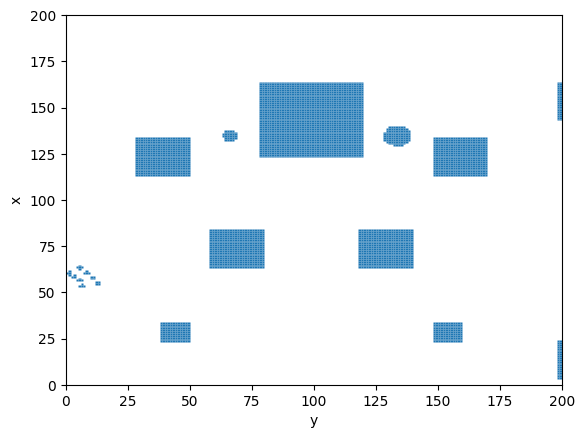

In [4]:
# read 2d coords (x,y) True if grid space occupied
import numpy as np
a = np.load('temp/zeta2_DQN_train/map_2d.npy')
plt_patches = []
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        if a[i, j]:
            patch = patches.Rectangle((j, i), 1, 1)
            plt_patches.append(patch)
# add list of patches (much quicker than iteratively drawing)
collection = PatchCollection(plt_patches, match_original=True)
plt.gca().add_collection(collection)
plt.xlim([0, a.shape[0]])
plt.ylim([0, a.shape[1]])
plt.xlabel('y')
plt.ylabel('x')
plt.show()

In [7]:
a[150, 100]

True

In [11]:
scale = 0.005
trans = np.array([-100, -100, -100])
res = np.absolute(trans) * 2 * scale
x = 50
y = 0
z = -4
_voxels_x = lambda x : int((x/res[1] - trans[1]))
_voxels_y = lambda y : int((y/res[0] - trans[0]))
_voxels_z = lambda z : int(((-1*z)/res[2] - trans[2]))
xi = _voxels_x(x)
yi = _voxels_y(y)
zi = _voxels_z(z)
print(xi, yi, zi)

150 100 104


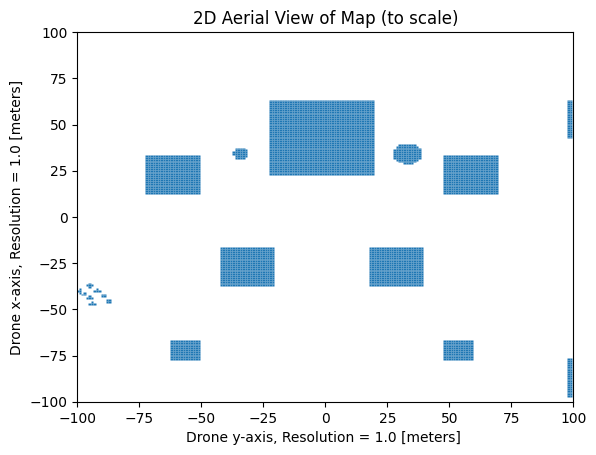

In [15]:
# read 2d coords (x,y) True if grid space occupied
import numpy as np
a = np.load('temp/zeta2_DQN_train/map_2d.npy')
plt_patches = []
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        if a[i, j]:
            x = (j + trans[1])*res[1]
            y = (i + trans[0])*res[0]
            patch = patches.Rectangle((x-res[1]/2, y-res[0]/2), res[1], res[0])
            plt_patches.append(patch)
# add list of patches (much quicker than iteratively drawing)
collection = PatchCollection(plt_patches, match_original=True)
plt.gca().add_collection(collection)
plt.xlim([res[1]*trans[1], -1*res[1]*trans[1]])
plt.ylim([res[0]*trans[0], -1*res[0]*trans[0]])
plt.title('2D Aerial View of Map (to scale)')
plt.xlabel(f'Drone y-axis, Resolution = {res[1]} [meters] ')
plt.ylabel(f'Drone x-axis, Resolution = {res[0]} [meters]')
plt.show()

In [2]:
from quad_mesh_simplify import simplify_mesh

ModuleNotFoundError: No module named 'quad_mesh_simplify'

In [3]:
import binvox as bv

In [6]:
b = bv.Binvox.read('maps/voxels/blocks_200_200_100_p5.binvox', 'dense')

In [8]:
b.axis_order

'xyz'

In [7]:
b.data

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal